In [690]:
#!conda install pandas -y

In [691]:
## モジュールの読み込み
import re, sys, os
import pprint as pp              # for use of pprint(..)
from pathlib import Path         # for file handling
import unicodedata
import random                    # for use of random.sample(..)
random.seed(12345)
#
import pandas as pd              # for effient data handling
pd.set_option("display.precision", 5)
#
import numpy as np               # for efficient calculation
np.random.seed(12345)

# 上位設定

In [692]:
## 全体
verbose = False

## 次の設定が False なら語形タイプで解析; True なら語形トークンで解析
analyze_by_tokens = False

## n_cores
import os
cpu_balancer = 2
n_cores = max(1, round(os.cpu_count()/cpu_balancer))
print(f"n_cores: {n_cores}")

## 可視化
run_visualization = False

n_cores: 4


In [693]:
## doc の設定
doc_size       = 'word'        # 名目変数: 名称のみ使用
doc_type       = 'form'        # 実効変数: document の単位
doc_attrs      = ['spell', 'sound']
doc_attr       = doc_attrs[0]  # 実効変数: spell, sound のどちらか
print(f"doc_attr: {doc_attr}")

## doc の最大文字数
max_doc_length   = 11 # 長過ぎる語形は除外
min_doc_length   =  5 # 短過ぎる語形は除外
print(f"max_doc_length: {max_doc_length}")
print(f"max_min_length: {min_doc_length}")

## add
boundary_symbol      = "#"
add_boundary_symbols = False # Arabic と整合しない？？
if add_boundary_symbols:
    hashed = "-hashed"
    effective_max_doc_length = max_doc_length + 2
    effective_min_doc_length = min_doc_length + 2
else:
    hashed = ""
    effective_max_doc_length = max_doc_length
    effective_min_doc_length = min_doc_length
    
## source sampling
source_sampling        = True
print(f"source_sampling: {source_sampling}")

## sample 1: 200; sample 2: 500; sample 3: 800; sample 4: 1200
sample_n_per_language  = 200
sample_n_per_language_original = sample_n_per_language
print(f"sample_n_per_language: {sample_n_per_language}")

doc_attr: spell
max_doc_length: 11
max_min_length: 5
source_sampling: True
sample_n_per_language: 200


# データの読込み

In [694]:
### データの準備
wd = Path(".")
dirs = [ x for x in wd.iterdir() if x.is_dir() ]
if verbose:
    print(f"The following {len(dirs)} directories are potential targets:")
    pp.pprint(dirs)

## 対象となるファイルから行を読み取る: ファイルのある directory は変更可能
if analyze_by_tokens:
    targetdir = "word-freqs"
else:
    targetdir = "data-words-1k-most-common"
#
data_files = [ ]
data_files.extend(list(wd.glob(f"{targetdir}/*.csv")))

## check sources
if verbose:
    for f in data_files:
        check_val = bool(re.match(r".*base.*", str(f)))
        print(f"{check_val} : {str(f)}")

## check file names
if verbose:
    print(f"\n{targetdir} contains {len(data_files)} files to process")
    pp.pprint(data_files)

In [695]:
### 属性 spell, sound 変数
attribute_names_text = "spell, sound"
attribute_names      = re.split(r",\s*", attribute_names_text)
print(f"attribute_names: {attribute_names}")

attribute_names: ['spell', 'sound']


In [696]:
### 言語名の設定
lang_names_text = "Arabic, Bengali, Chinese, English, Old_English, Esperanto, Finnish, French, German, Greek, Hebrew, Hungarian, Icelandic, Irish, Italian, Russian, Spanish, Swahili, Turkish, Japanese, Korean"
#
lang_names = re.split(r",\s*", lang_names_text)
print(f"lang_names:\n{lang_names}")
#
lang_name_keys = [ x.lower() for x in lang_names ] 
print(f"lang_name_keys:\n{lang_name_keys}")

lang_names:
['Arabic', 'Bengali', 'Chinese', 'English', 'Old_English', 'Esperanto', 'Finnish', 'French', 'German', 'Greek', 'Hebrew', 'Hungarian', 'Icelandic', 'Irish', 'Italian', 'Russian', 'Spanish', 'Swahili', 'Turkish', 'Japanese', 'Korean']
lang_name_keys:
['arabic', 'bengali', 'chinese', 'english', 'old_english', 'esperanto', 'finnish', 'french', 'german', 'greek', 'hebrew', 'hungarian', 'icelandic', 'irish', 'italian', 'russian', 'spanish', 'swahili', 'turkish', 'japanese', 'korean']


In [697]:
### 言語名の選別
target_langs_text1a = "english"
target_langs_text2a = "english, french"
target_langs_text2b = "english, german"
target_langs_text2c = "english, old_english"
target_langs_text3a = "english, french, german"
target_langs_text3b = "arabic, english, russian"
target_langs_text4a = "english, french, german, spanish"
target_langs_text5  = "arabic, english, french, german, russian"
target_langs_text6  = "arabic, english, french, german, greek, russian"
target_langs_text8  = "arabic, english, french, finnish, turkish, icelandic, greek, russian"
#
target_langs = re.split(r",\s*", target_langs_text5)
print(f"target_langs:\n{target_langs}")
##
target_langs_code = "".join(map(lambda x: x[0].upper(), target_langs))
print(f"target_langs_code: {target_langs_code}")

target_langs:
['arabic', 'english', 'french', 'german', 'russian']
target_langs_code: AEFGR


In [698]:
## sample_n の補正
import math
n_target_langs = len(target_langs)
if sample_n_per_language == sample_n_per_language_original:
    sample_n_per_language = sample_n_per_language_original
sample_n_per_language = round(sample_n_per_language * (0.1 + 1/math.log(1 + n_target_langs)))
print(f"sample_n_per_lang: {sample_n_per_language}")

sample_n_per_lang: 132


### df 構築

In [699]:
## 文章ごとに df に格納 (ただし後で一つにまとめる)
import pandas as pd
import itertools, os

check = False
dfs = [ ]
for i, file in enumerate([ str(f) for f in data_files]):
    print(file)
    ## 対象ファイルのpath を指定し，内容を読み取る
    file_name = os.path.basename(file)
    ## attribute の設定
    attribute_vals = {}
    for attribute_name in attribute_names:
        pattern = f".*-{attribute_name}-.*"
        if bool(re.match(pattern, file_name)):
            print(f"filename matched: {pattern}")
            print(f"for attribute_name: {attribute_name}")
            attribute_vals[attribute_name] = 1
        else:
            attribute_vals[attribute_name] = 0
    
    ## 言語名の設定
    lang_name_vals = {}
    for lang_name in lang_names:
        #print(f"lang_name: {lang_name}")
        pattern = f".*-{lang_name}-.*" # capitalize してマッチ判定
        lang_key = lang_name.lower()
        #print(f"lang_key: {lang_key}")
        if bool(re.match(pattern, file_name)):
            print(f"filename matched: {pattern}")
            print(f"for lang_name_key: {lang_key}")
            lang_name_vals[lang_key] = 1
        else:
            lang_name_vals[lang_key] = 0
    else:
        pass
    
    ## check
    if check:
        print(f"attribute_vals: {attribute_vals}")
        print(f"lang_name_vals: {lang_name_vals}" )
    
    ## .csv ファイルの最初の行は header で，そこで word, freq の変数名を宣言する
    with open(file, encoding = 'utf8') as f:
        dfx = pd.read_csv(file, on_bad_lines = 'skip')
        
        ## confirm Unicode character attribute
        dfx[doc_attr] = dfx[doc_type].apply(lambda x: unicodedata.normalize('NFC', str(x)))
        
        ## class と言語名を設定 
        for key, val in itertools.chain(attribute_vals.items(), lang_name_vals.items()):
            #print(f"key: {key}; val: {val}")
            dfx[key] = val
        
        ## text の値を設定
        dfx['text']    = i
        dfs.append(dfx)
## 統合
dfx = pd.concat(dfs)

data-words-1k-most-common/base-spell-Spanish-r0-1k-mc.csv
filename matched: .*-spell-.*
for attribute_name: spell
filename matched: .*-Spanish-.*
for lang_name_key: spanish
data-words-1k-most-common/base-spell-Chinese-r0-1k-mc.csv
filename matched: .*-spell-.*
for attribute_name: spell
filename matched: .*-Chinese-.*
for lang_name_key: chinese
data-words-1k-most-common/base-sound-Japanese-r0-1k-mc.csv
filename matched: .*-sound-.*
for attribute_name: sound
filename matched: .*-Japanese-.*
for lang_name_key: japanese
data-words-1k-most-common/base-spell-Hebrew-r0-1k-mc.csv
filename matched: .*-spell-.*
for attribute_name: spell
filename matched: .*-Hebrew-.*
for lang_name_key: hebrew
data-words-1k-most-common/base-sound-French-r0-opendic-s900.csv
filename matched: .*-sound-.*
for attribute_name: sound
filename matched: .*-French-.*
for lang_name_key: french
data-words-1k-most-common/base-sound-English-r6e-original.csv
filename matched: .*-sound-.*
for attribute_name: sound
filename matc

In [700]:
## dfは語形 word と頻度 freq と元ファイル text = i の三つ組
if verbose:
    dfx

In [701]:
def ifelse(checker, t = 1, f = 0):
    if checker:
        return t
    else:
        return f

dfx['proper'] = dfx['form'].apply(lambda x: ifelse('_' in x or '-' in x, 0, 1))
dfx['proper'].value_counts()

proper
1    35984
0      132
Name: count, dtype: int64

In [702]:
## hyphen と underscore のある語を除外
dfx = dfx[dfx['proper'] == 1]

In [703]:
## size 列の追加
#dfx['size'] = dfx['form'].apply(len)
dfx['size'] = dfx[doc_type].apply(len)

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_46934/1655230148.py:16: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



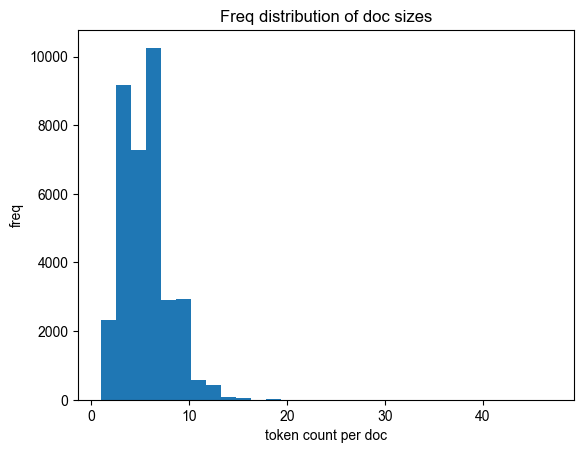

In [704]:
## 文字数の分布を確認
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(dfx['size'], bins = 30)
ax.set_xlabel('token count per doc')
ax.set_ylabel('freq')
if add_boundary_symbols:
    title_text = "Freq distribution of doc sizes (boundaries included)"
else:
    title_text = "Freq distribution of doc sizes"
ax.set_title(title_text)
#
fig.show()

In [705]:
## doc を長さで濾過
original_dfx_size = len(dfx)
dfx = dfx[(dfx['size'] <= effective_max_doc_length) & (dfx['size'] >= effective_min_doc_length)]
print(f"number of remaining docs: {len(dfx)}")
print(f"discarded {original_dfx_size - len(dfx)} docs due to size filter")

number of remaining docs: 23917
discarded 12067 docs due to size filter


In [706]:
## spell の事例数の確認
dfx['spell'].value_counts(sort = True)

spell
1    13940
0     9977
Name: count, dtype: int64

In [707]:
## sound の事例数の確認
dfx['sound'].value_counts(sort = True)

sound
0    13940
1     9977
Name: count, dtype: int64

In [708]:
## language 列を追加
check = False
language = []
for i, row in dfx.iterrows(): # i, row でないとダメ
    if check:
        print(row)
    n_matches = sum(row[lang_name_keys])
    if n_matches == 0:
        language.append('UNUSED')
    elif n_matches > 1:
        language.append('MULTIPLE')
    else:
        for lang_name in lang_name_keys:
            if row[lang_name] == 1:
                language.append(lang_name)
#
dfx['language'] = language
dfx['language'].value_counts(sort = True)

language
english        6103
french         1521
spanish        1499
icelandic      1286
chinese        1217
swahili        1191
german         1086
arabic         1069
esperanto      1052
italian         773
finnish         763
greek           748
russian         716
irish           675
UNUSED          666
japanese        664
turkish         660
hungarian       634
korean          591
bengali         530
hebrew          335
old_english     138
Name: count, dtype: int64

In [709]:
## 言語の事例数の確認
for lang in lang_name_keys:
    print(dfx[lang].value_counts(sort = True))

arabic
0    22848
1     1069
Name: count, dtype: int64
bengali
0    23387
1      530
Name: count, dtype: int64
chinese
0    22700
1     1217
Name: count, dtype: int64
english
0    17814
1     6103
Name: count, dtype: int64
old_english
0    23779
1      138
Name: count, dtype: int64
esperanto
0    22865
1     1052
Name: count, dtype: int64
finnish
0    23154
1      763
Name: count, dtype: int64
french
0    22396
1     1521
Name: count, dtype: int64
german
0    22831
1     1086
Name: count, dtype: int64
greek
0    23169
1      748
Name: count, dtype: int64
hebrew
0    23582
1      335
Name: count, dtype: int64
hungarian
0    23283
1      634
Name: count, dtype: int64
icelandic
0    22631
1     1286
Name: count, dtype: int64
irish
0    23242
1      675
Name: count, dtype: int64
italian
0    23144
1      773
Name: count, dtype: int64
russian
0    23201
1      716
Name: count, dtype: int64
spanish
0    22418
1     1499
Name: count, dtype: int64
swahili
0    22726
1     1191
Name: count, dty

In [710]:
## 解析対象がタイプ集合かトークン集合か選ぶ: 頻度を反映させない場合はタイプ集合となる
## 頻度を反映させたトークン集合で解析する方が自然な結果を与えると期待できる
check = False
if analyze_by_tokens:
    L = [ ]
    for i, row in dfx.iterrows():
        if check:
            print(f"row: {row}")
        L.extend(list([row]) * int(row['freq']))
    dfy = pd.DataFrame(L, columns = dfx.columns)
    ## freq の削除
    dfy = dfy.drop(columns = ['freq'])
    ## 置き換え
    dfx = dfy
#
print(f"{len(dfx)} tokens generated")

23917 tokens generated


# 解析の準備

In [711]:
## term の設定
term_size    = 'char'   # 名目変数: 名称のみ使用

## term 設定
discard_too_frequent_unigrams = False
too_frequents_discard_rate    = 0.001

## n-gram を包括的にする (= n-gram が (n-1)-gram) を含むかどうか
ngram_is_inclusive = True
print(f"ngram_is_inclusive: {ngram_is_inclusive}")

## n for ngram
build_more_than_3grams = False
print(f"build_more_than_3grams: {build_more_than_3grams}")

## skipiness
use_skippy_ngrams      = True
print(f"use_skippy_ngrams: {use_skippy_ngrams}")

## extended skippy ngrams
add_extended_skippy_ngrams = True

## skippy n-grams の最大 gap 設定: 値が小さい方が依存の局所性を捉えるかも
max_gap_ratio = 0.33
print(f"max_gap_ratio: {max_gap_ratio}")
max_gap_size  = round(max_doc_length * max_gap_ratio)
print(f"max_gap_size: {max_gap_size}")

ngram_is_inclusive: True
build_more_than_3grams: False
use_skippy_ngrams: True
max_gap_ratio: 0.33
max_gap_size: 4


In [712]:
## word か spell のクラスを選択
print(f"targeted subtype: {doc_attr}")
dfx = dfx[dfx[doc_attr] == 1] # doc_subtype の値は word か spell
print(f"<{doc_attr}> has {len(dfx)} instances")

targeted subtype: spell
<spell> has 13940 instances


In [713]:
## 言語の選別
import pandas as pd
print(f"targeted languages: {target_langs}")

df_targeted = pd.DataFrame()
for lang in target_langs:
    df_targeted = pd.concat([df_targeted, dfx[dfx[lang] == 1]])
#
df_targeted

targeted languages: ['arabic', 'english', 'french', 'german', 'russian']


,form,freq,spell,sound,arabic,bengali,chinese,english,old_english,esperanto,...,russian,spanish,swahili,turkish,japanese,korean,text,proper,size,language
17,بواسطة,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,31,1,6,arabic
37,البعض,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,31,1,5,arabic
40,القيام,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,31,1,6,arabic
42,الوقت,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,31,1,5,arabic
51,مجموعة,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,31,1,6,arabic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,требовать,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,12,1,9,russian
990,широкий,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,12,1,7,russian
991,подготовить,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,12,1,11,russian
996,претензии,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,12,1,9,russian


In [714]:
## データ名の確定 with sampling
if source_sampling:
    df_temp = pd.DataFrame()
    for lang in set(df_targeted['language']):
        sub_df_by_lang = df_targeted[df_targeted['language'] == lang]
        if len(sub_df_by_lang) > sample_n_per_language:
            sub_df_by_lang_sampled = sub_df_by_lang.sample(sample_n_per_language)
            df_temp = pd.concat([df_temp, sub_df_by_lang_sampled])
        else:
            df_temp = pd.concat([df_temp, sub_df_by_lang])
    df = df_temp
else:
    df = df_targeted
##
df

,form,freq,spell,sound,arabic,bengali,chinese,english,old_english,esperanto,...,russian,spanish,swahili,turkish,japanese,korean,text,proper,size,language
465,kleid,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,28,1,5,german
257,licht,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,28,1,5,german
324,schüler,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,28,1,7,german
209,haupt,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,28,1,5,german
66,unten,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,28,1,5,german
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,положение,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,12,1,9,russian
115,человек,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,12,1,7,russian
464,достичь,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,12,1,7,russian
744,возбуждать,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,12,1,10,russian


In [715]:
## 語形に小文字化を適用
## 次はファイル間に重複があった時に面倒
#W_base = list(set([ x.lower() for x in df['word'].values]))
W_base = df[doc_type].apply(lambda x: x.lower())
print(f"nrows: {len(W_base)}")
W_base.sample(10)

nrows: 660


466        الوصول
1925        india
501        الطاقة
340         stadt
3486    sloppiest
276     bannister
687        الكثير
2645     ostertag
934      выиграть
64          umzug
Name: form, dtype: object

In [716]:
## df[doc_type] を小文字化したものに置き換え
df[doc_type] = W_base
df[doc_type]

465         kleid
257         licht
324       schüler
209         haupt
66          unten
          ...    
543     положение
115       человек
464       достичь
744    возбуждать
222       никогда
Name: form, Length: 660, dtype: object

In [717]:
## add boundary symbols
if add_boundary_symbols:
    df[doc_type] = df[doc_type].apply(lambda x: f"{boundary_symbol}{x}{boundary_symbol}")
    df[doc_type]

## n-gram 生成

In [718]:
## 文字 1-gram 生成
import re
term_sep = r""
raw_unigrams = df[doc_type].apply(lambda x: re.split(term_sep, x))
raw_unigrams = [ [ x for x in u if len(x) > 0 and not x is None ] for u in raw_unigrams ]

In [719]:
## 高頻度 1-grams の除外
print(f"discard_too_frequent_unigrams: {discard_too_frequent_unigrams}")
if discard_too_frequent_unigrams:
    from functools import reduce
    all_unigrams = reduce(lambda x, y: x+ y, raw_unigrams, [])
    from collections import Counter
    term_freqs = Counter(all_unigrams)
    too_frequent_unigrams = term_freqs.most_common(round(len(term_freqs) * too_frequents_discard_rate))

    print(f"too_frequent_unigrams to discard: {too_frequent_unigrams}")
    unigrams = [ u for u in raw_unigrams if not u in too_frequent_unigrams ]
else:
    unigrams = raw_unigrams

discard_too_frequent_unigrams: False


In [720]:
## 文字 1gram 列を追加
df['1gram'] = unigrams
df['1gram']

465                   [k, l, e, i, d]
257                   [l, i, c, h, t]
324             [s, c, h, ü, l, e, r]
209                   [h, a, u, p, t]
66                    [u, n, t, e, n]
                    ...              
543       [п, о, л, о, ж, е, н, и, е]
115             [ч, е, л, о, в, е, к]
464             [д, о, с, т, и, ч, ь]
744    [в, о, з, б, у, ж, д, а, т, ь]
222             [н, и, к, о, г, д, а]
Name: 1gram, Length: 660, dtype: object

In [721]:
## 文字 2-gram 生成
import gen_ngrams
bigrams = df['1gram'].apply(lambda x: gen_ngrams.gen_ngrams(x, n = 2, sep = "", check = False))

## 包括的 2gramの生成
if ngram_is_inclusive:
    for i, b in enumerate(bigrams):
        b.extend(list(df['1gram'])[i]) ## list(...) is crucial

## 2gram 列を追加
df['2gram'] = bigrams
df['2gram']

465                      [kl, le, ei, id, k, l, e, i, d]
257                      [li, ic, ch, ht, l, i, c, h, t]
324        [sc, ch, hü, ül, le, er, s, c, h, ü, l, e, r]
209                      [ha, au, up, pt, h, a, u, p, t]
66                       [un, nt, te, en, u, n, t, e, n]
                             ...                        
543    [по, ол, ло, ож, же, ен, ни, ие, п, о, л, о, ж...
115        [че, ел, ло, ов, ве, ек, ч, е, л, о, в, е, к]
464        [до, ос, ст, ти, ич, чь, д, о, с, т, и, ч, ь]
744    [во, оз, зб, бу, уж, жд, да, ат, ть, в, о, з, ...
222        [ни, ик, ко, ог, гд, да, н, и, к, о, г, д, а]
Name: 2gram, Length: 660, dtype: object

In [722]:
## 文字 3-gram 生成
import gen_ngrams
trigrams = df['1gram'].apply(lambda x: gen_ngrams.gen_ngrams(x, n = 3, sep = "", check = False))

## 包括的 3gramの生成
if ngram_is_inclusive:
    for i, t in enumerate(trigrams):
        t.extend(list(df['2gram'])[i])

## 3gram 列を追加
df['3gram'] = trigrams
df['3gram']

465       [kle, lei, eid, kl, le, ei, id, k, l, e, i, d]
257       [lic, ich, cht, li, ic, ch, ht, l, i, c, h, t]
324    [sch, chü, hül, üle, ler, sc, ch, hü, ül, le, ...
209       [hau, aup, upt, ha, au, up, pt, h, a, u, p, t]
66        [unt, nte, ten, un, nt, te, en, u, n, t, e, n]
                             ...                        
543    [пол, оло, лож, оже, жен, ени, ние, по, ол, ло...
115    [чел, ело, лов, ове, век, че, ел, ло, ов, ве, ...
464    [дос, ост, сти, тич, ичь, до, ос, ст, ти, ич, ...
744    [воз, озб, збу, буж, ужд, жда, дат, ать, во, о...
222    [ник, ико, ког, огд, гда, ни, ик, ко, ог, гд, ...
Name: 3gram, Length: 660, dtype: object

In [723]:
## 文字 4-gram 生成
if build_more_than_3grams:
    import gen_ngrams
    quadrigrams = df['1gram'].apply(lambda x: gen_ngrams.gen_ngrams(x, n = 4, sep = "", check = False))

    ## 包括的 4gramの生成
    if ngram_is_inclusive:
        for i, q in enumerate(quadrigrams):
            q.extend(list(df['3gram'])[i])

    ## 2gram 列を追加
    df['4gram'] = quadrigrams
    df['4gram']

In [724]:
## 文字の sk 2-grams を構築
import gen_ngrams
sk2grams = df['1gram'].apply(lambda x: gen_ngrams.gen_sk_ngrams(x, n = 2, sep = "", max_distance = max_gap_size, check = False))

## 包括 sk 2-grams の構築
if ngram_is_inclusive:
    for i, b2 in enumerate(sk2grams):
        b2.extend(list(df['1gram'])[i]) ## list(...) is crucial

## sk2gram 列の追加
df['sk2gram'] = sk2grams
df['sk2gram']

465    [kl, k…e, k…i, k…d, le, l…i, l…d, ei, e…d, id,...
257    [li, l…c, l…h, l…t, ic, i…h, i…t, ch, c…t, ht,...
324    [sc, s…h, s…ü, s…l, ch, c…ü, c…l, hü, h…l, ül,...
209    [ha, h…u, h…p, h…t, au, a…p, a…t, up, u…t, pt,...
66     [un, u…t, u…e, u…n, nt, n…e, n…n, te, t…n, en,...
                             ...                        
543    [по, п…л, п…о, п…ж, ол, о…о, о…ж, ло, л…ж, ож,...
115    [че, ч…л, ч…о, ч…в, ел, е…о, е…в, ло, л…в, ов,...
464    [до, д…с, д…т, д…и, ос, о…т, о…и, ст, с…и, ти,...
744    [во, в…з, в…б, в…у, оз, о…б, о…у, зб, з…у, бу,...
222    [ни, н…к, н…о, н…г, ик, и…о, и…г, ко, к…г, ог,...
Name: sk2gram, Length: 660, dtype: object

In [725]:
## 文字の sk 3-gram を構築
import gen_ngrams
sk3grams = df['1gram'].apply(lambda x: gen_ngrams.gen_sk_ngrams(x, n = 3, sep = "", max_distance = max_gap_size, check = False))

## 包括 sk 3-grams の構築
if ngram_is_inclusive:
    for i, t2 in enumerate(sk3grams):
        t2.extend(list(sk2grams)[i])

## sk3gram 列の追加
df['sk3gram'] = sk3grams
df['sk3gram']

465    [kle, kl…i, kl…d, k…ei, k…e…d, k…id, lei, le…d...
257    [lic, li…h, li…t, l…ch, l…c…t, l…ht, ich, ic…t...
324    [sch, sc…ü, sc…l, s…hü, s…h…l, s…ül, chü, ch…l...
209    [hau, ha…p, ha…t, h…up, h…u…t, h…pt, aup, au…t...
66     [unt, un…e, un…n, u…te, u…t…n, u…en, nte, nt…n...
                             ...                        
543    [пол, по…о, по…ж, п…ло, п…л…ж, п…ож, оло, ол…ж...
115    [чел, че…о, че…в, ч…ло, ч…л…в, ч…ов, ело, ел…в...
464    [дос, до…т, до…и, д…ст, д…с…и, д…ти, ост, ос…и...
744    [воз, во…б, во…у, в…зб, в…з…у, в…бу, озб, оз…у...
222    [ник, ни…о, ни…г, н…ко, н…к…г, н…ог, ико, ик…г...
Name: sk3gram, Length: 660, dtype: object

In [726]:
## 文字の sk 4-gram を構築
if build_more_than_3grams:
    import gen_ngrams
    sk4grams = df['1gram'].apply(lambda x: gen_ngrams.gen_sk_ngrams(x, n = 4, sep = "", max_distance = max_gap_size, check = False))

    ## 包括 sk 4-grams の構築
    if ngram_is_inclusive:
        for i, q2 in enumerate(sk4grams):
            q2.extend(list(df['sk3gram'])[i])

    ## sk2gram 列の追加
    df['sk4gram'] = sk4grams
    df['sk4gram']

In [727]:
## 文字の xsk 2-grams を構築
if add_extended_skippy_ngrams:
    import gen_ngrams
    xsk2grams = df['1gram'].apply(lambda x: gen_ngrams.gen_ext_sk_ngrams(x, n = 2, sep = "", max_distance = max_gap_size, check = False))

    ## 包括 xsk 2-grams の構築
    if ngram_is_inclusive:
        for i, b2 in enumerate(xsk2grams):
            b2.extend(list(df['1gram'])[i]) ## list(...) is crucial

    ## sk2gram 列の追加
    df['xsk2gram'] = xsk2grams
    df['xsk2gram']

In [728]:
## 文字の xsk 3-grams を構築
if add_extended_skippy_ngrams:
    import gen_ngrams
    xsk3grams = df['1gram'].apply(lambda x: gen_ngrams.gen_ext_sk_ngrams(x, n = 3, sep = "", max_distance = max_gap_size, check = False))

    ## 包括 xsk 3-grams の構築
    if ngram_is_inclusive:
        for i, b2 in enumerate(xsk3grams):
            b2.extend(list(df['xsk2gram'])[i]) ## list(...) is crucial

    ## sk3gram 列の追加
    df['xsk3gram'] = xsk3grams
    df['xsk3gram']

In [729]:
## 文字の xsk 4-grams を構築
if build_more_than_3grams and add_extended_skippy_ngrams:
    import gen_ngrams
    xsk4grams = df['1gram'].apply(lambda x: gen_ngrams.gen_ext_sk_ngrams(x, n = 4, sep = "", max_distance = max_gap_size, check = False))

    ## 包括 xsk 4-grams の構築
    if ngram_is_inclusive:
        for i, b2 in enumerate(xsk4grams):
            b2.extend(list(df['xsk3gram'])[i]) ## list(...) is crucial

    ## sk4gram 列の追加
    df['xsk4gram'] = xsk4grams
    df['xsk4gram']

In [730]:
## 順序をランダマイズ
from sklearn.utils import shuffle
df = shuffle(df)
df

,form,freq,spell,sound,arabic,bengali,chinese,english,old_english,esperanto,...,proper,size,language,1gram,2gram,3gram,sk2gram,sk3gram,xsk2gram,xsk3gram
753,chaise,1,1,0,0,0,0,0,0,0,...,1,6,french,"[c, h, a, i, s, e]","[ch, ha, ai, is, se, c, h, a, i, s, e]","[cha, hai, ais, ise, ch, ha, ai, is, se, c, h,...","[ch, c…a, c…i, c…s, ha, h…i, h…s, ai, a…s, is,...","[cha, ch…i, ch…s, c…ai, c…a…s, c…is, hai, ha…s...","[ch…, c…a…, c…i…, c…s…, …ha…, …h…i…, …h…s…, …a...","[c…ha…, c…h…i…, c…h…s…, c…ai…, c…a…s…, c…is…, ..."
196,around,1.0,1,0,0,0,0,1,0,0,...,1,6,english,"[a, r, o, u, n, d]","[ar, ro, ou, un, nd, a, r, o, u, n, d]","[aro, rou, oun, und, ar, ro, ou, un, nd, a, r,...","[ar, a…o, a…u, a…n, ro, r…u, r…n, ou, o…n, un,...","[aro, ar…u, ar…n, a…ou, a…o…n, a…un, rou, ro…n...","[ar…, a…o…, a…u…, a…n…, …ro…, …r…u…, …r…n…, …o...","[a…ro…, a…r…u…, a…r…n…, a…ou…, a…o…n…, a…un…, ..."
61,домой,1,1,0,0,0,0,0,0,0,...,1,5,russian,"[д, о, м, о, й]","[до, ом, мо, ой, д, о, м, о, й]","[дом, омо, мой, до, ом, мо, ой, д, о, м, о, й]","[до, д…м, д…о, д…й, ом, о…о, о…й, мо, м…й, ой,...","[дом, до…о, до…й, д…мо, д…м…й, д…ой, омо, ом…й...","[до…, д…м…, д…о…, д…й, …ом…, …о…о…, …о…й, …мо…...","[д…ом…, д…о…о…, д…о…й, д…мо…, д…м…й, д…ой, …о…..."
4034,valin,1.0,1,0,0,0,0,1,0,0,...,1,5,english,"[v, a, l, i, n]","[va, al, li, in, v, a, l, i, n]","[val, ali, lin, va, al, li, in, v, a, l, i, n]","[va, v…l, v…i, v…n, al, a…i, a…n, li, l…n, in,...","[val, va…i, va…n, v…li, v…l…n, v…in, ali, al…n...","[va…, v…l…, v…i…, v…n, …al…, …a…i…, …a…n, …li…...","[v…al…, v…a…i…, v…a…n, v…li…, v…l…n, v…in, …a…..."
1787,higher,1.0,1,0,0,0,0,1,0,0,...,1,6,english,"[h, i, g, h, e, r]","[hi, ig, gh, he, er, h, i, g, h, e, r]","[hig, igh, ghe, her, hi, ig, gh, he, er, h, i,...","[hi, h…g, h…h, h…e, ig, i…h, i…e, gh, g…e, he,...","[hig, hi…h, hi…e, h…gh, h…g…e, h…he, igh, ig…e...","[hi…, h…g…, h…h…, h…e…, …ig…, …i…h…, …i…e…, …g...","[h…ig…, h…i…h…, h…i…e…, h…gh…, h…g…e…, h…he…, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,choisir,1,1,0,0,0,0,0,0,0,...,1,7,french,"[c, h, o, i, s, i, r]","[ch, ho, oi, is, si, ir, c, h, o, i, s, i, r]","[cho, hoi, ois, isi, sir, ch, ho, oi, is, si, ...","[ch, c…o, c…i, c…s, ho, h…i, h…s, oi, o…s, is,...","[cho, ch…i, ch…s, c…oi, c…o…s, c…is, hoi, ho…s...","[ch…, c…o…, c…i…, c…s…, …ho…, …h…i…, …h…s…, …o...","[c…ho…, c…h…i…, c…h…s…, c…oi…, c…o…s…, c…is…, ..."
663,lager,1,1,0,0,0,0,0,0,0,...,1,5,german,"[l, a, g, e, r]","[la, ag, ge, er, l, a, g, e, r]","[lag, age, ger, la, ag, ge, er, l, a, g, e, r]","[la, l…g, l…e, l…r, ag, a…e, a…r, ge, g…r, er,...","[lag, la…e, la…r, l…ge, l…g…r, l…er, age, ag…r...","[la…, l…g…, l…e…, l…r, …ag…, …a…e…, …a…r, …ge…...","[l…ag…, l…a…e…, l…a…r, l…ge…, l…g…r, l…er, …a…..."
559,sommeil,1,1,0,0,0,0,0,0,0,...,1,7,french,"[s, o, m, m, e, i, l]","[so, om, mm, me, ei, il, s, o, m, m, e, i, l]","[som, omm, mme, mei, eil, so, om, mm, me, ei, ...","[so, s…m, s…m, s…e, om, o…m, o…e, mm, m…e, me,...","[som, so…m, so…e, s…mm, s…m…e, s…me, omm, om…e...","[so…, s…m…, s…m…, s…e…, …om…, …o…m…, …o…e…, …m...","[s…om…, s…o…m…, s…o…e…, s…m…, s…m…e…, s…me…, …..."
135,منخفض,1,1,0,1,0,0,0,0,0,...,1,5,arabic,"[م, ن, خ, ف, ض]","[من, نخ, خف, فض, م, ن, خ, ف, ض]","[منخ, نخف, خفض, من, نخ, خف, فض, م, ن, خ, ف, ض]","[من, م…خ, م…ف, م…ض, نخ, ن…ف, ن…ض, خف, خ…ض, فض,...","[منخ, من…ف, من…ض, م…خف, م…خ…ض, م…فض, نخف, نخ…ض...","[من…, م…خ…, م…ف…, م…ض, …نخ…, …ن…ف…, …ن…ض, …خف…...","[م…نخ…, م…ن…ف…, م…ن…ض, م…خف…, م…خ…ض, م…فض, …ن…..."


# 解析: dominancy, purity の計算 => term_type ごとに処理反復

## n_topics ループの起点

In [ ]:
## LDA 用の設定

## topics 数
n_topics = 6 ## topic 数の指定: spell だと10で十分に大きい
print(f"n_topics: {n_topics}")

## min_freq; determines the number of documents covered by term
term_min_freq = 2 # originally 2
print(f"min_freq: {term_min_freq}")

## abuse_rate: 値が小さい程，(小さい ntop で)エンコード不良が起こりやすい
## GenSim 版でのみ有効
abuse_rates  = [0.01, 0.1, 0.33, 0.5, 0.67, 0.9, 0.99]
term_abuse_rate   = abuse_rates[-2]
print(f"abuse_rate: {term_abuse_rate}")

## encoding options
use_FastText      = False
use_FastText_only = False

## Labeled LDA or not
labeled_LDA = True
if labeled_LDA:
    labeled_sig = "(Labeled)"
else:
    labeled_sig = ""

## Multicore を生かすか (GenSim 用)
run_LDA_in_parallel = True
print(f"run_LDA_in_parallel: {run_LDA_in_parallel}")

n_topics: 5
min_freq: 2
abuse_rate: 0.9
run_LDA_in_parallel: True


## 関数定義

In [790]:
## install umap-learn for UMAP if necessary
#!conda install umap-learn -y

In [791]:
def draw_3D_plot (df, color_var: str, title: str, check: bool = False, debugged: bool = False):
    "3D 可視化"
    if debugged:
        print(df)
    
    ## データ
    #X, Y, Z = df.iloc[:, 0], df.iloc[:, 1], df.iloc[:, 2]
    X, Y, Z = df['D1'], df['D2'], df['D3']
    if check:
        print(f"X: {X}")
        print(f"Y: {Y}")
        print(f"Z: {Z}")
    
    ## 色分け設定
    color_vals = df[color_var]
    try:
        color_vals = list(map(lambda x: int(x), color_vals))
    except (ValueError, TypeError):
        color_dict = {}
        for i, val in enumerate(sorted(np.unique(color_vals), reverse = False)):
            color_dict[val] = i + 1 # increment base to deal with outliers
        color_vals = df[color_var].apply(lambda x: color_dict[x])
    
    ## 配色
    import plotly.express as pex
    #colorscale_val =  pex.colors.cyclical.mygbm
    colorscale_val = pex.colors.qualitative.Plotly
    ##
    import plotly.graph_objects as go
    fig = go.Figure(
        data = [go.Scatter3d(x = X, y = Y, z = Z, mode = 'markers',
                             marker = dict(size = 5, color = color_vals,
                                           colorscale = colorscale_val,))
                ],
        layout = go.Layout(title = go.layout.Title(text = title))
    )

    ## 3D 散布図にラベルを追加する処理は未実装
    fig.update_layout(autosize = False, width = 600, height = 600,)
    fig.update_traces(marker_size = 3)
    fig.show()

In [792]:
def apply_LDA_by_GenSim (df, term_type: str, n_topics: int, min_freq: int, abuse_rate: float, n_cores: int, apply_term_filtering: bool = True, run_LDA_in_parallel: bool = True, check: bool = False):
    "LDA の実行 (GenSim 版)"
    
    print(f"applying LDA by GenSim")
    ## LDA 構築の基になる dictionary = document-term matrix (dtm) を構築
    from gensim.corpora.dictionary import Dictionary
    diction = Dictionary(df[term_type])
    print(diction)
    original_diction_size = len(diction)
    
    ## 高い頻度 token を確認
    top_ratio = 0.03
    if check:
        top_n = round(len(df[term_type]) * top_ratio)
        diction.most_common(top_n)
    
    ## diction の濾過
    import copy
    diction_copy = copy.deepcopy(diction) # 必須

    ## term 濾過の実行
    if apply_term_filtering:
        # docs 被覆率: 大きくし過ぎない
        print(f"min_freq: {min_freq}")
        # 対象外とする語の濫用指標: 小さくし過ぎないように
        print(f"abuse_rate: {abuse_rate}")
        diction_copy.filter_extremes(no_below = min_freq, no_above = abuse_rate)

    ## check
    print(diction_copy)
    new_diction_size = len(diction_copy)
    print(f"removed {(original_diction_size - new_diction_size)} tokens")
    
    ## dtm データの選択
    diction = diction_copy

    ## bots を構築
    bots = [ diction.doc2bow(term) for term in df[term_type] ]
    print(f"number of unique tokens: {len(diction)}")
    print(f"number of documents: {len(bots)}")
    
    ## sanitize
    bots = [ bot for bot in bots if len(bot) > 0 ]
    print(f"number of sanitized documents: {len(bots)}")
    
    ## bots のLDA モデルの構築
    if run_LDA_in_parallel:
        from gensim.models import LdaMulticore
        lda_model_ = LdaMulticore(bots,
                    id2word = diction,
                    num_topics = n_topics, 
                    alpha = 0.001, #alpha = 'auto',
                    workers = n_cores)
    else:
        from gensim.models import LdaModel
        lda_model_ = LdaModel(bots,
                    id2word = diction,
                    num_topics = n_topics, 
                    alpha = 'auto')
    ##
    return diction, bots, lda_model_

In [793]:
def apply_LDA_by_TomotoPy (df, term_type: str, n_topics: int, term_min_freq: int, term_abuse_rate: float, target_label_name: None, apply_term_filtering: bool = True, n_iter: int = 100, check: bool = False):
    "LDA の実行 (TomotoPy 版)"
    
    import tomotopy as tp
    print(f"applying LDA by TomotoPy")

    ## set up for text
    bots = df[term_type]

    ## set up for labels
    if target_label_name:
        target_labels = df[target_label_name]
    else:
        target_labels = []
    
    ## term filtering
    min_df = 0
    rm_top_val = 0
    if apply_term_filtering:
        min_cf_val = term_min_freq
        #rm_top_val = round(len(bots) * (1 - term_abuse_rate))
    else:
        min_cf_val = 0 # default value
    ##
    if len(target_labels) > 0:
        tomoto_lda_model = tp.LLDAModel(k = n_topics, seed = 1234, min_cf = min_cf_val, rm_top = rm_top_val)
        for text, label in zip(bots, target_labels):
            tomoto_lda_model.add_doc(text, labels = label)
    else:
        tomoto_lda_model = tp.LDAModel(k = n_topics, seed = 1234, min_cf = min_cf_val, rm_top = rm_top_val)
        for text in bots:
            tomoto_lda_model.add_doc(text)
    
    ##
    diction = list(tomoto_lda_model.used_vocabs) # experimental

    ## 
    tomoto_lda_model.train(iter = n_iter)

    ##
    return diction, bots, tomoto_lda_model

In [794]:
def apply_FastText (df, n_topics: int, ft_term_type: str, ft_token_sep: str = " ", check: bool = False):
    from gensim.models import FastText
    print(f"applying FastText")
    #
    ft_scaling_factors = [1, 2, 3, 4, 5]
    ft_scaling_factor  = ft_scaling_factors[0] # effective value is unknown
    ft_n_dims          = round (ft_scaling_factor * n_topics)
    ft_window_size     = 5
    print(f"ft_term_type: {ft_term_type}")
    print(f"ft_n_dims: {ft_n_dims}")
    print(f"ft_window_size: +/-{ft_window_size}")
    
    ## emulate sentences by concatenating character 1-grams by whitespaces
    ft_corpus = df[ft_term_type].apply(lambda x: ft_token_sep.join(x))
    ## build a model: for better comparison, vector_size should be equal to n_topics
    ft_model = FastText(ft_corpus,
                        vector_size = ft_n_dims,
                        window = ft_window_size,
                        min_count = 1, sg = 1)
    ## ft_model は dict
    return ft_corpus.apply(lambda doc: ft_model.wv[doc])

In [795]:
def run_pyLDAvis (lda_model, bots, diction, n_cores: int, use_MMDS: bool = False, use_tSNE: bool = False, check: bool = False):
    "pyLDAvis を使った結果の可視化: 階層クラスタリングより詳しい"
    import pyLDAvis
    installed_version = pyLDAvis.__version__
    print(f"installed pyLDAvis version: {installed_version}")
    if float(installed_version[:3]) > 3.0:
        import pyLDAvis.gensim_models as gensimvis
    else:
        import pyLDAvis.gensim as gensimvis
    ##
    pyLDAvis.enable_notebook()
    if use_MMDS:
        vis = gensimvis.prepare(lda_model, bots, diction, n_jobs = n_cores, sort_topics = False, mds = 'mmds')
    elif use_tSNE:
        vis = gensimvis.prepare(lda_model, bots, diction, n_jobs = n_cores, sort_topics = False, mds = 'tsne')
    else:
        vis = gensimvis.prepare(lda_model, bots, diction, n_jobs = n_cores, sort_topics = False)
    ##
    #pyLDAvis.display(vis)
    vis # works but disallows graphics manipulation
    return vis

In [796]:
def filter_df_by_std (df, enc_key: str = 'enc', check: bool = False):
    "一様分布の事例を除外"
    from scipy.stats import tstd # standard deviation の計算用
    print(f"{len(df)} instances before filtering")
    doc_enc = df[enc_key]
    ##
    max_std = max([ tstd(x) for x in doc_enc])
    print(f"std max: {max_std}")
    min_std = min([ tstd(x) for x in doc_enc])
    if check:
        print(f"std min: {min_std}")
    first_min_std = list(sorted(set([ tstd(x) for x in doc_enc])))[-0]
    print(f"std 1st min: {first_min_std}")
    second_min_std = list(sorted(set([ tstd(x) for x in doc_enc])))[-1]
    print(f"std 2nd min: {second_min_std}")

    ## 閾値は2番目に小さい値より小さく最小値よりは大きな値であるべき
    divider = 4
    std_threshold = second_min_std / divider # 穏健な値を得るために4で割った
    print(f"std_threshold: {std_threshold:0.3}")
    ##
    filtered_ins = [ False if tstd(x) < std_threshold else True for x in df[enc_key] ]
    df_filtered = df[ filtered_ins ]
    print(f"{len(df_filtered)} instances remain after filtering ({len(df) - len(df_filtered)} instances removed)")
    ##
    return df_filtered

In [797]:
def show_encoding_dist (doc_df, term_type: str, enc_key: str = 'enc', enc_sampling_rate: float = 0.2):
    "エンコード値の分布を確認"
    import pandas as pd
    Enc_sampled = [ sorted(x, reverse = True) for x
                            in doc_df.sample(round(len(doc_df) * enc_sampling_rate))[enc_key] ]
    Enc_sampled_sorted = sorted(Enc_sampled, reverse = True)

    ## 分布の描画
    plt.figure(figsize = (4, 4)) # This needs to be run here, before dendrogram construction.
    plt.plot(range(0, len(Enc_sampled_sorted)), Enc_sampled_sorted)
    plt.title(f"Sorted distribution of sampled {len(Enc_sampled)} encodings via {term_type}-based LDA ({n_topics} topics)")
    plt.show()

In [798]:
def apply_ICA (doc_df, n_dims: int = 3, enc_key: str = 'enc', check: bool = False):
    print(f"running ICA ... takes a while")
    from sklearn.decomposition import FastICA
    ica = FastICA(n_components = n_dims)
    ## transform data before application
    from sklearn.preprocessing import StandardScaler
    data_scaler = StandardScaler()
    import numpy as np
    scaled_data = data_scaler.fit_transform(np.array(list(doc_df[enc_key])))
    ## application
    return ica.fit_transform(np.array(list(scaled_data)))

In [799]:
def apply_PCA (doc_df, n_dims: int = 3, enc_key: str = 'enc', check: bool = False):
    print(f"running PCA ... takes a while")
    from sklearn.decomposition import PCA
    pca = PCA(n_components = n_dims)
    ## application
    import numpy as np
    return pca.fit_transform(np.array(list(doc_df[enc_key])))

In [800]:
def apply_PLS (doc_df, n_dims: int = 3, enc_key: str = 'enc', reversed_output: bool = False, check: bool = False):
    print(f"running PCA ... takes a while")
    from sklearn.cross_decomposition import PLSRegression
    pls_reducer = PLSRegression(n_components = n_dims)
    ## application
    import numpy as np
    data = np.array(list(doc_df[enc_key]))
    if reversed_output:
        return pls_reducer.fit_transform(data, data)[1]
    else:
        return pls_reducer.fit_transform(data, data)[0]

In [801]:
def apply_MDS (doc_df, n_dims: int = 3, enc_key: str = 'enc', check: bool = False):
    print(f"running MDS ... takes a while")
    ## set parameters
    mds_dissimilarities = ['euclidean', # default
                  'precomputed']
    mds_dissimilarity = mds_dissimilarities[0] # defaults to minkowski
    print(f"mds_dissimilarity: {mds_dissimilarity}")
    ##
    from sklearn.manifold import MDS
    reducer = MDS (n_components = n_dims, dissimilarity = mds_dissimilarity)
    ## application
    import numpy as np
    return reducer.fit_transform(np.array(list(doc_df[enc_key])))

In [802]:
def apply_LLE (doc_df, n_dims: int = 3, enc_key: str = 'enc', check: bool = False):
    print(f"running LLE ... takes a while")
    ## set parameters
    lle_methods = ['standard', # default
                  'hessian', 'modified', 'ltsa']
    lle_method = lle_methods[2] # standard works poorly
    print(f"lle_method: {lle_method}")
    lle_neighborhood_rate = 0.01 # greater values group instances more strongly
    lle_n_neighbors = round(len(doc_df) * lle_neighborhood_rate)
    assert lle_n_neighbors > 2
    ##
    from sklearn.manifold import LocallyLinearEmbedding as LLE
    reducer = LLE (n_components = n_dims, n_neighbors = lle_n_neighbors, method = lle_method)
    ## application
    import numpy as np
    return reducer.fit_transform(np.array(list(doc_df[enc_key]))), lle_n_neighbors

In [803]:
def apply_Isomap (doc_df, n_dims: int = 3, enc_key: str = 'enc', check: bool = False):
    print(f"running Isomap ... takes a while")
    ## set parameters
    isomap_metrics = ['minkowski', # default, works fine
                    'correlation', # works
                    'cosine', # ineffective
                    'euclidean', # works but poorly
                    'canberra', 'braycurtis', 'manhattan',
                    'mahalanobis' # needs additional argument
                ]
    isomap_metric = isomap_metrics[0] # defaults to minkowski
    print(f"isomap_metric: {isomap_metric}")
    ## n_neighbors
    isomap_neighborhood_rate = 0.08 # greater values group instances more strongly
    isomap_n_neighbors = round(len(doc_df) * isomap_neighborhood_rate)
    assert isomap_n_neighbors > 2
    ##
    from sklearn.manifold import Isomap
    reducer = Isomap (n_components = n_dims, n_neighbors = isomap_n_neighbors, metric = isomap_metric)
    ## application
    import numpy as np
    return reducer.fit_transform(np.array(list(doc_df[enc_key]))), isomap_n_neighbors

In [804]:
def apply_UMAP (doc_df, n_cores: int, n_dims: int = 3, enc_key: str = 'enc', run_UMAP_in_parallel: bool = True, check: bool = False):
    "UMAP"
    print(f"running UMAP ... takes a while")
    ## set parameters
    umap_metrics = ['correlation', # works, but gives funny result
                    'cosine', # works better than correlation
                    'euclidean',
                    'canberra', 'braycurtis', 'manhattan',
                    'minkowski', # takes time
                    'mahalanobis' # fails
                ]
    umap_metric = umap_metrics[1] # correlation, cosine worked.
    print(f"umap_metric: {umap_metric}")
    ## n_neighbors
    umap_neighborhood_rate = 0.004 # 0.004 gave a nice result
    umap_n_neighbors = round(len(doc_df) * umap_neighborhood_rate)
    assert umap_n_neighbors > 2
    print(f"umap_n_neighbors: {umap_n_neighbors}")
    ## min_dist: stronger aggregation with smaller values
    umap_min_dists   = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    umap_min_dist    = umap_min_dists[-2]
    print(f"umap_min_dist: {umap_min_dist}")
    
    ## creater reducer
    import umap
    reducer = umap.UMAP (n_components = n_dims, metric = umap_metric, n_neighbors = umap_n_neighbors, min_dist = umap_min_dist, n_jobs = n_cores)
    ## application
    import numpy as np
    return reducer.fit_transform(np.array(list(doc_df[enc_key]))), umap_n_neighbors, umap_min_dist

In [805]:
def apply_tSNE (doc_df, n_topics, n_dims: int = 3, enc_key: str = 'enc', doc_perplexity_is_fixed: bool = False, doc_perplexity_depends_on_n_topics: bool = True, check: bool = False):
    print(f"running t-SNE ... takes a while")
    ## set parameters
    print(f"perplexity_depends_on_n_topics: {doc_perplexity_depends_on_n_topics}")
    ## set rates
    if doc_perplexity_depends_on_n_topics:
        doc_perplexity_reduct_rate = 3.0
        print(f"doc_perplexity_reduct_rate: {doc_perplexity_reduct_rate} relative to n_topics")
    else:
        doc_perplexity_reduct_rate = 0.1
        print(f"doc_perplexity_reduct_rate: {doc_perplexity_reduct_rate} relative to sample size")
    ## set values
    if doc_perplexity_is_fixed:
        doc_perplexity_val = 100
    else:
        print(f"doc_perplexity_depends_on_n_topics: {doc_perplexity_depends_on_n_topics}")
        print(f"scaling factor: {doc_perplexity_reduct_rate}")
        if doc_perplexity_depends_on_n_topics:
            doc_perplexity_val = round(n_topics * doc_perplexity_reduct_rate)
        else:
            doc_perplexity_val = round(len(doc_df) * doc_perplexity_reduct_rate)
    print(f"doc_perplexity_val: {doc_perplexity_val}")
        
    ## t-SNE を使った docs のグループ化 (3D): 時間がかかる
    from sklearn.manifold import TSNE as tSNE
    try:
        if n_dims > 3:
            reducer = tSNE(n_components = n_dims, random_state = 0,
                perplexity = doc_perplexity_val, max_iter = 1000, method = 'exact')
        else:
            reducer = tSNE(n_components = n_dims, random_state = 0,
                perplexity = doc_perplexity_val, max_iter = 1000)
    except TypeError:
        if n_dims > 3:
            reducer = tSNE(n_components = n_dims, random_state = 0,
                perplexity = doc_perplexity_val, n_iter = 1000, method = 'exact')
        else:
            reducer = tSNE(n_components = n_dims, random_state = 0,
                perplexity = doc_perplexity_val, n_iter = 1000)

    ## データに適用
    import numpy as np
    return reducer.fit_transform(np.array(list(doc_df[enc_key]))), doc_perplexity_val

In [806]:
def draw_plot_df (df, perplexity_val: int, term_type: str, n_topics: int, color_key: str, check: bool = False):
    "可視化"
    import plotly
    import plotly.express as px
    plotly.graph_objs.layout.Colorscale = px.colors.qualitative.Plotly
    title_val = f"t-SNE (ppl: {perplexity_val}) of {len(df)} docs via {term_type}-based LDA {labeled_sig} ({n_topics} topics; abuse_rate: {term_abuse_rate})"
    ##
    #fig = pex.scatter_3d(df, x = 'D1', y = 'D2', z = 'D3', color = color_key, title = title_val)
    
    ## t-SNE の結果の可視化 (3D)
    import plotly.graph_objects as go

    ## 図の大きさを決める
    X, Y, Z = df.loc[:,0], df.loc[:,1], df.loc[:,2]
    fig = go.Figure(data = [go.Scatter3d(x = X, y = Y, z = Z,
                                        mode = 'markers', marker = dict(size = 7))])

    ## 3D 散布図にラベルを追加する処理は未実装
    fig.update_layout(autosize = False, width = 600, height = 600)
    fig.update_traces(marker_size = 3)
    fig.show()

In [807]:
def apply_DBSCAN (dbscan_source, n_topics, check: bool = False):
    "DBSCAN でクラスタリング"
    
    import numpy as np
    from sklearn.cluster import DBSCAN
    from collections import Counter

    print(f"running DBSCAN ...")
    
    ## DBSCAN 用の設定
    allowed_outlier_rate = 0.05 # originally 0.03
    min_samples_val_rate = 0.003
    eps_scaling_factor   = 2
    
    ## 許容する outlier の個数
    n_allowed_outliers   = round(len(dbscan_source) * allowed_outlier_rate)
    print(f"n_allowed_outliers: {n_allowed_outliers}")

    ## min_samples はデータ数に依存
    min_samples_val = round(min_samples_val_rate * len(dbscan_source))
    if min_samples_val < 2:
        min_samples_val = 2
    print(f"min_samples_val: {min_samples_val}")

    ## eps は事例ごとに調節が必要
    max_eps_val     = round(n_topics * eps_scaling_factor)
    final_eps_val   = None
    dbscan_results  = []
    check = False
    for eps_val in np.arange(max_eps_val, 0.001, -0.05): # (..., 0.001, -0.1) worked
        if check:
            print(f"trying eps: {eps_val}")
        final_eps_val = eps_val
        dbscan_result = DBSCAN(eps = eps_val, min_samples = min_samples_val).fit(dbscan_source)
        cluster_labels = dbscan_result.labels_
        clustering_counts = Counter(cluster_labels)
        if check:
            print(f"n_clusters: {len(clustering_counts)}")
        if clustering_counts[-1] < n_allowed_outliers:
            dbscan_results.append(dbscan_result)
        else:
            break
    ##
    return cluster_labels, clustering_counts, final_eps_val

In [808]:
def get_purity (C: object, check: bool = False):
    count_sum = sum (C.values())
    dominant = C.most_common(1)[0] # C is colllections.Counter object
    dominant_lang, count = dominant
    if check:
        print(f"dominant_lang: {dominant_lang}; count: {count}")
    return (dominant_lang, count, count/count_sum)    

In [809]:
def gen_purity_dict (df, purity_min_population: int, cluster_key: str = 'cluster', language_key: str = 'languge', check: bool = False):
    ##
    import numpy as np
    from collections import Counter
    purity_dict_by_cluster = { }
    for cluster_id in np.unique(df[cluster_key]):
        if check:
            print(f"cluster: {cluster_id}")
        if cluster_id == -1:
            continue
        ##
        sub_df = df[df[cluster_key] == cluster_id]
        clustwise_dist = Counter(sub_df[language_key])
        if check:
            print(clustwise_dist)
        if sum(clustwise_dist.values()) > purity_min_population:
            purity_dict_by_cluster[cluster_id] = get_purity(clustwise_dist, check = False)
    #
    if check:
        purity_dict_by_cluster
    return purity_dict_by_cluster

In [810]:
def get_F_value (x: float, y: float):
    if x == 0 and y == 0:
        return 0
    else:
        return 2 * x * y/(x + y)

## 本処理: dominancy d, purity p, F(d, p) の計算

In [811]:
## clustering purity
purity_min_population_rate = 0.004 # tentative: originally 0.007; 0.01 turned out to be too large

## purity の設定
purity_threshold = 0.33 # originally 0.33

## purity target の設定
restrict_purity_targets    = False
if restrict_purity_targets:
    purity_target_langs = ['arabic', 'russian']
else:
    purity_target_langs = target_langs

## term_types 設定
use_extended_skippy_ngrams = False
reduce_term_types = False
if reduce_term_types:
    used_term_types = ['1gram', '2gram', '3gram']
elif use_extended_skippy_ngrams:
    if build_more_than_3grams:
        used_term_types = ['1gram', '2gram', '3gram', '4gram', 'sk2gram', 'sk3gram', 'sk4gram',  'xsk2gram', 'xsk3gram', 'xsk4gram']
    else:
        used_term_types = ['1gram', '2gram', '3gram', 'sk2gram', 'sk3gram', 'xsk2gram', 'xsk3gram']
else:
    if build_more_than_3grams:
        used_term_types = ['1gram', '2gram', '3gram', '4gram', 'sk2gram', 'sk3gram', 'sk4gram']
    else:
        used_term_types = ['1gram', '2gram', '3gram', 'sk2gram', 'sk3gram']
print(f"used_term_types: {used_term_types}")

used_term_types: ['1gram', '2gram', '3gram', 'sk2gram', 'sk3gram']


In [812]:
## to solve "ImportError: cannot import name 'triu' from 'scipy.linalg'"
#!conda install "scipy<1.13" -y

In [813]:
## main: term_type ごとに処理を反復
use_labeled_LDA = True # requires TomotoPy
visualize_doc_3d_reduced   = False

## dimension reducer の選択
## ICA, PCA はこのデータのトポロジーの表現にばっちり？！ n_topics が大き過ぎない限り？
## MDS は時間がかかるし，表現に向いていない
## LLE は速いが表現力不足．使えない．
## Isomap は metric を選ぶし．凝集が弱い．
## t-SNE は（遅いが）良いクラスターが生じるが，調整が必要
## UMAP は凝集が強過ぎる．パラメーター設定がむずかしい

target_n_dims = 3
dim_reducers  = ['ICA', 'PCA', 'PLS', 'MDS', 'LLE', 'Isomap', 'UMAP', 'tSNE']
dim_reducer   =  dim_reducers[-1]
print(f"dim_reducer: {dim_reducer}")
doc_perplexity_is_fixed    = False # effective for tSNE only

diction_dict   = {}
bots_dict      = {}
lda_model_dict = {}
plot_dfs       = {}

import pandas as pd
dominancy_df = pd.DataFrame()
purity_df    = pd.DataFrame()
for term_type in used_term_types:
    print(f"=============================\nProceesing term_type: {term_type}")
    ##
    if use_TomotoPy:
        diction, bots, lda_model = apply_LDA_by_TomotoPy (df, term_type, n_topics, term_min_freq, term_abuse_rate, 'language')
    else:
        diction, bots, lda_model = apply_LDA_by_GenSim (df, term_type, n_topics, term_min_freq, term_abuse_rate, n_cores)
    print(lda_model)
    
    ## diction, bots, LDA model の登録
    diction_dict[term_type]   = diction
    bots_dict[term_type]      = bots
    lda_model_dict[term_type] = lda_model
    
    ## get LDA encoding
    if use_TomotoPy:
        doc_lda_encodings = [ doc.get_topic_dist() for doc in lda_model.docs ]
    else:
        raw_lda_encodings = df[term_type].apply(lambda x:
                                        lda_model.get_document_topics (diction.doc2bow(x), minimum_probability = 0))
        doc_lda_encodings = [ [ x[-1] for x in enc ] for enc in raw_lda_encodings ] # This is the trick!

    ## get FastText encoding
    if use_FastText:
        ft_term_type = term_type.replace("sk", "") # ft_term is the anti-skippy version of n-gram
        print(f"ft_term_type: {ft_term_type}")
        doc_ft_encodings = apply_FastText (df, n_topics, ft_term_type)

    ## doc_encoding の定義
    if use_FastText:
        if use_FastText_only:
            doc_encoding = "ft"
            encoding_method = "FT"
            print(f"use FastText encoding only")
            doc_encodings = doc_ft_encodings
        else:
            print(f"add FastText encoding to LDA encoding")
            if use_labeled_LDA:
                doc_encoding = "lda(labeled)-ft"
                encoding_method = "LDA (labeled) x FT"
            else:
                doc_encoding = "lda-ft"
                encoding_method = "LDA x FT"
            doc_encodings = [ [*x, *y] for x, y in zip(doc_ft_encodings, doc_lda_encodings) ]
            #doc_encodings = [ np.reshape(np.concatenate([x, y], dtype = object) , -1) for x, y in zip(doc_ft_encodings, doc_lda_encodings) ]
    else:
        print(f"use LDA encoding only")
        if use_labeled_LDA:
            doc_encoding = "lda(labeled)"
            encoding_method = "LDA (labeled)"
        else:
            doc_encoding = "lda"
            encoding_method = "LDA"
        doc_encodings = doc_lda_encodings
    
    # df['enc'] 追加
    df['enc'] = doc_encodings
    
    ## std が異常な行を除外
    df = filter_df_by_std (df)
    
    ## 重複を削除
    doc_df = df.drop_duplicates(doc_type)
    
    ## doc の異なりを得る
    df[doc_type].value_counts()
    
    ## 確認
    doc_df[used_term_types]
    
    if verbose:
        show_encoding_dist(doc_df, term_type)

    ## encoding の次元削減
    if  dim_reducer == 'PCA':
        doc_reduced = apply_PCA (doc_df, target_n_dims)
    elif dim_reducer == 'ICA':
        doc_reduced = apply_ICA (doc_df, target_n_dims)
    elif dim_reducer == 'PLS':
        doc_reduced = apply_PLS (doc_df, target_n_dims)
    elif dim_reducer == 'MDS':
        doc_reduced = apply_MDS (doc_df, target_n_dims)
    elif dim_reducer == 'LLE':
        doc_reduced, lle_n_neighbors = apply_LLE (doc_df, target_n_dims)
    elif dim_reducer == 'Isomap':
        doc_reduced, isomap_n_neighbors = apply_Isomap (doc_df, target_n_dims)
    elif dim_reducer == 'UMAP':
        doc_reduced, umap_n_neighbors, min_dist = apply_UMAP(doc_df, n_cores, target_n_dims)
    elif dim_reducer == 'tSNE':
        doc_reduced, doc_perplexity_val = apply_tSNE(doc_df, n_topics, target_n_dims)
    else:
        raise "dim_reducer is undefined"
    ##
    #try:
    #    plot_df = pd.DataFrame(doc_reduced, columns = ['D1', 'D2', 'D3'])    
    #except TypeError:
    #    pass
    plot_df = pd.DataFrame(doc_reduced, columns = ['D1', 'D2', 'D3'])
    plot_df.loc[:,'language'] = list(doc_df['language']) # Crucially, list(..)
    plot_df.loc[:,'enc']      = list(doc_df['enc']) # Crucially, list(..)
    plot_df.loc[:,doc_type]   = list(doc_df[doc_type]) # Crucially, list(..)
    #plot_df = pd.DataFrame(plot_df_base, columns = , 'language', 'enc', 'form'])
    
    ## visualization
    if visualize_doc_3d_reduced:
        draw_plot_df (plot_df, doc_perplexity_val, term_type, n_topics, 'language', check = True)
    
    ## DBSCAN clustering
    dbscan_source = doc_reduced
    final_cluster_labels, clustering_counts, final_eps_val = apply_DBSCAN (dbscan_source, n_topics)
    ##
    print(f"final_eps: {final_eps_val}")
    print(f"n_clusters: {len(clustering_counts)}")
    print(f"final_cluster_counts: {clustering_counts}")

    ## update plot_df
    plot_df['cluster'] = final_cluster_labels
    if verbose:
        plot_df
    
    ## plot_df の保存
    plot_dfs[term_type] = plot_df

    ## min_population の設定
    min_population_for_purity = round(len(plot_df) * purity_min_population_rate)
    print(f"min_population_for_purity: {min_population_for_purity}")
    
    purity_dict_by_cluster = gen_purity_dict(plot_df, min_population_for_purity, 'cluster', 'language')
    
    ## dominancy の geometrical mean
    from scipy.stats import gmean as geomean
    dominancy_dict = {}
    for target_lang in purity_target_langs:
        dominancy_geomean = geomean([v[-1] for v in purity_dict_by_cluster.values() if v[0] == target_lang])
        print(f"{target_lang} dominancy_geomean: {dominancy_geomean:0.3f}")
        dominancy_dict[target_lang] = dominancy_geomean
    dominancy_df[term_type] = dominancy_dict
    
    ## purity: threshold 越えの cluster の割合
    purity_dict, impurity_dict = {}, {}
    for target_lang in purity_target_langs:
        ##
        pure_clusters, impure_clusters = {}, {}
        for cluster_id, v in purity_dict_by_cluster.items():
            if v[0] == target_lang:
                if v[-1] > purity_threshold:
                    pure_clusters[cluster_id] = v
                else:
                    impure_clusters[cluster_id] = v
        #
        cluster_size = len([id for id, v in purity_dict_by_cluster.items() if v[0] == target_lang])
        try:
            purity_ratio = len(pure_clusters)/cluster_size
        except ZeroDivisionError:
            purity_ratio = 0
        purity_dict[target_lang] = purity_ratio
        print(f"{target_lang} purity_ratio: {purity_ratio:0.3f}")
        #
        try:
            impurity_ratio = len(impure_clusters)/cluster_size
        except ZeroDivisionError:
            impurity_ratio = 0
        impurity_dict[target_lang] = impurity_ratio
        if verbose:
            print(f"{target_lang} impurity_ratio: {impurity_ratio:0.3f}")
            print(f"{target_lang} purity + impurity: {(impurity_ratio + purity_ratio):0.3f}")
    #
    purity_df[term_type] = purity_dict

dim_reducer: tSNE
Proceesing term_type: 1gram
applying LDA by TomotoPy
use LDA encoding only
660 instances before filtering


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_46934/4119310578.py:26: DeprecationWarning:

`tomotopy.LLDAModel` is deprecated. Please use `tomotopy.PLDAModel` instead.

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_46934/4119310578.py:28: RuntimeWarning:

`labels` should be an iterable of str.

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_46934/4119310578.py:38: RuntimeWarning:

The training result may differ even with fixed seed if `workers` != 1.



std max: 0.267246812582016
std 1st min: 0.18112534284591675
std 2nd min: 0.267246812582016
std_threshold: 0.0668
660 instances remain after filtering (0 instances removed)
running t-SNE ... takes a while
perplexity_depends_on_n_topics: True
doc_perplexity_reduct_rate: 3.0 relative to n_topics
doc_perplexity_depends_on_n_topics: True
scaling factor: 3.0
doc_perplexity_val: 15
running DBSCAN ...
n_allowed_outliers: 33
min_samples_val: 2
final_eps: 9.499999999999993
n_clusters: 127
final_cluster_counts: Counter({10: 45, 97: 36, -1: 33, 30: 30, 18: 21, 31: 20, 37: 14, 4: 13, 61: 13, 66: 13, 14: 12, 6: 9, 33: 8, 40: 8, 41: 8, 42: 8, 63: 8, 32: 7, 34: 7, 44: 7, 45: 7, 13: 6, 94: 6, 99: 6, 0: 5, 5: 5, 19: 5, 20: 5, 23: 5, 24: 5, 26: 5, 28: 5, 29: 5, 50: 5, 57: 5, 71: 5, 78: 5, 84: 5, 91: 5, 120: 5, 2: 4, 7: 4, 8: 4, 9: 4, 11: 4, 12: 4, 17: 4, 22: 4, 36: 4, 43: 4, 49: 4, 56: 4, 69: 4, 93: 4, 98: 4, 113: 4, 1: 3, 35: 3, 38: 3, 46: 3, 47: 3, 48: 3, 53: 3, 54: 3, 55: 3, 62: 3, 64: 3, 67: 3, 72: 3

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_46934/4119310578.py:26: DeprecationWarning:

`tomotopy.LLDAModel` is deprecated. Please use `tomotopy.PLDAModel` instead.

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_46934/4119310578.py:28: RuntimeWarning:

`labels` should be an iterable of str.

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_46934/4119310578.py:38: RuntimeWarning:

The training result may differ even with fixed seed if `workers` != 1.



std max: 0.2668588161468506
std 1st min: 0.1438143402338028
std 2nd min: 0.2668588161468506
std_threshold: 0.0667
660 instances remain after filtering (0 instances removed)
running t-SNE ... takes a while
perplexity_depends_on_n_topics: True
doc_perplexity_reduct_rate: 3.0 relative to n_topics
doc_perplexity_depends_on_n_topics: True
scaling factor: 3.0
doc_perplexity_val: 15
running DBSCAN ...
n_allowed_outliers: 33
min_samples_val: 2
final_eps: 4.749999999999925
n_clusters: 95
final_cluster_counts: Counter({2: 34, -1: 33, 21: 29, 11: 25, 50: 22, 19: 21, 30: 20, 7: 19, 14: 17, 46: 16, 12: 15, 1: 14, 10: 13, 17: 12, 8: 11, 36: 11, 40: 10, 44: 10, 67: 10, 23: 9, 35: 9, 51: 9, 0: 8, 13: 8, 27: 8, 32: 8, 38: 8, 52: 8, 9: 7, 20: 7, 28: 7, 53: 7, 70: 7, 3: 6, 6: 6, 54: 6, 61: 6, 15: 5, 22: 5, 26: 5, 47: 5, 55: 5, 62: 5, 63: 5, 66: 5, 76: 5, 84: 5, 16: 4, 29: 4, 31: 4, 42: 4, 43: 4, 60: 4, 68: 4, 75: 4, 78: 4, 91: 4, 5: 3, 18: 3, 34: 3, 39: 3, 41: 3, 45: 3, 49: 3, 56: 3, 64: 3, 69: 3, 79: 3,

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_46934/4119310578.py:26: DeprecationWarning:

`tomotopy.LLDAModel` is deprecated. Please use `tomotopy.PLDAModel` instead.

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_46934/4119310578.py:28: RuntimeWarning:

`labels` should be an iterable of str.

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_46934/4119310578.py:38: RuntimeWarning:

The training result may differ even with fixed seed if `workers` != 1.



std max: 0.26678207516670227
std 1st min: 0.12028322368860245
std 2nd min: 0.26678207516670227
std_threshold: 0.0667
660 instances remain after filtering (0 instances removed)
running t-SNE ... takes a while
perplexity_depends_on_n_topics: True
doc_perplexity_reduct_rate: 3.0 relative to n_topics
doc_perplexity_depends_on_n_topics: True
scaling factor: 3.0
doc_perplexity_val: 15
running DBSCAN ...
n_allowed_outliers: 33
min_samples_val: 2
final_eps: 4.299999999999919
n_clusters: 110
final_cluster_counts: Counter({-1: 35, 14: 22, 22: 19, 4: 16, 27: 16, 28: 16, 0: 15, 5: 15, 9: 14, 44: 13, 49: 13, 56: 12, 75: 11, 1: 10, 6: 10, 26: 10, 29: 10, 31: 10, 62: 10, 66: 10, 7: 9, 15: 9, 25: 9, 41: 9, 71: 9, 23: 8, 34: 8, 54: 8, 58: 8, 59: 8, 93: 8, 16: 7, 50: 7, 60: 7, 78: 7, 94: 7, 30: 6, 35: 6, 45: 6, 52: 6, 83: 6, 85: 6, 8: 5, 10: 5, 33: 5, 46: 5, 64: 5, 72: 5, 73: 5, 77: 5, 96: 5, 3: 4, 17: 4, 20: 4, 24: 4, 37: 4, 43: 4, 63: 4, 69: 4, 80: 4, 81: 4, 82: 4, 101: 4, 105: 4, 12: 3, 13: 3, 21: 3,

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_46934/4119310578.py:26: DeprecationWarning:

`tomotopy.LLDAModel` is deprecated. Please use `tomotopy.PLDAModel` instead.

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_46934/4119310578.py:28: RuntimeWarning:

`labels` should be an iterable of str.

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_46934/4119310578.py:38: RuntimeWarning:

The training result may differ even with fixed seed if `workers` != 1.



std max: 0.2668799161911011
std 1st min: 0.13248427212238312
std 2nd min: 0.2668799161911011
std_threshold: 0.0667
660 instances remain after filtering (0 instances removed)
running t-SNE ... takes a while
perplexity_depends_on_n_topics: True
doc_perplexity_reduct_rate: 3.0 relative to n_topics
doc_perplexity_depends_on_n_topics: True
scaling factor: 3.0
doc_perplexity_val: 15
running DBSCAN ...
n_allowed_outliers: 33
min_samples_val: 2
final_eps: 0.7499999999998685
n_clusters: 117
final_cluster_counts: Counter({-1: 36, 39: 21, 1: 19, 35: 17, 8: 16, 5: 15, 21: 15, 42: 15, 13: 14, 29: 14, 9: 11, 18: 11, 38: 11, 10: 10, 12: 10, 20: 10, 11: 9, 27: 9, 31: 9, 43: 9, 44: 9, 58: 9, 55: 8, 83: 8, 3: 7, 23: 7, 60: 7, 64: 7, 70: 7, 80: 7, 85: 7, 88: 7, 2: 6, 32: 6, 36: 6, 53: 6, 63: 6, 65: 6, 0: 5, 17: 5, 19: 5, 40: 5, 41: 5, 46: 5, 47: 5, 50: 5, 54: 5, 61: 5, 89: 5, 4: 4, 7: 4, 16: 4, 34: 4, 37: 4, 52: 4, 59: 4, 66: 4, 68: 4, 78: 4, 84: 4, 87: 4, 91: 4, 96: 4, 98: 4, 100: 4, 104: 4, 109: 4, 112

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_46934/4119310578.py:26: DeprecationWarning:

`tomotopy.LLDAModel` is deprecated. Please use `tomotopy.PLDAModel` instead.

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_46934/4119310578.py:28: RuntimeWarning:

`labels` should be an iterable of str.

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_46934/4119310578.py:38: RuntimeWarning:

The training result may differ even with fixed seed if `workers` != 1.



use LDA encoding only
660 instances before filtering
std max: 0.2670363187789917
std 1st min: 0.1102432832121849
std 2nd min: 0.2670363187789917
std_threshold: 0.0668
660 instances remain after filtering (0 instances removed)
running t-SNE ... takes a while
perplexity_depends_on_n_topics: True
doc_perplexity_reduct_rate: 3.0 relative to n_topics
doc_perplexity_depends_on_n_topics: True
scaling factor: 3.0
doc_perplexity_val: 15
running DBSCAN ...
n_allowed_outliers: 33
min_samples_val: 2
final_eps: 0.7999999999998693
n_clusters: 104
final_cluster_counts: Counter({-1: 37, 1: 28, 14: 21, 20: 21, 7: 16, 16: 16, 34: 16, 50: 16, 38: 14, 17: 13, 28: 12, 4: 11, 10: 11, 23: 11, 18: 10, 25: 10, 40: 10, 51: 10, 71: 10, 3: 9, 13: 9, 15: 9, 24: 9, 39: 9, 53: 9, 5: 8, 9: 8, 11: 8, 22: 8, 41: 8, 6: 7, 8: 7, 61: 7, 76: 7, 2: 6, 19: 6, 33: 6, 37: 6, 44: 6, 47: 6, 55: 6, 57: 6, 70: 6, 75: 6, 84: 6, 27: 5, 30: 5, 32: 5, 42: 5, 43: 5, 77: 5, 0: 4, 12: 4, 64: 4, 65: 4, 68: 4, 69: 4, 78: 4, 88: 4, 21: 3, 2

In [814]:
dominancy_df

,1gram,2gram,3gram,sk2gram,sk3gram
arabic,1.00000,1.00000,1.00000,1.00000,1.00000
english,1.00000,0.72683,0.66359,0.73015,0.80665
french,0.93194,0.76062,0.75155,0.79274,0.87853
german,0.97966,0.82342,0.80070,0.84537,0.78889
russian,1.00000,1.00000,1.00000,1.00000,0.98674


In [815]:
purity_df

,1gram,2gram,3gram,sk2gram,sk3gram
arabic,1.0,1.0,1.0,1.0,1.0
english,1.0,1.0,1.0,1.0,1.0
french,1.0,1.0,1.0,1.0,1.0
german,1.0,1.0,1.0,1.0,1.0
russian,1.0,1.0,1.0,1.0,1.0


In [816]:
## F(d,p) の計算
F_value_dict = {}
for x, ds in dominancy_df.iterrows():
    for y, ps in purity_df.iterrows():
        col_names = ps.keys()
        i = 0
        for d, p in zip(ds, ps):
            term_key = col_names[i]
            if x == y:
                row_name = f"{x}-{term_key}"
                f = get_F_value (d, p)
                if check:
                    print(f"{row_name:10s}: {f}")
                F_value_dict[row_name] = f
            i = i + 1
#
import pandas as pd
F_value_df = pd.DataFrame.from_dict(F_value_dict, orient = 'index', columns = [f"{n_topics}"])

In [817]:
F_value_df

,5
arabic-1gram,1.00000
arabic-2gram,1.00000
arabic-3gram,1.00000
arabic-sk2gram,1.00000
arabic-sk3gram,1.00000
english-1gram,1.00000
english-2gram,0.84181
english-3gram,0.79778
english-sk2gram,0.84403
english-sk3gram,0.89298


In [818]:
doc_encoding

'lda(labeled)'

In [819]:
## save dominacy_df, purity_df and F_value_df
if dim_reducer in ['PCA','tSNE', 'UMAP']:
    save_results = True
else:
    save_results = False
##
save_dominacies_and_purities = True
if save_results:
    import datetime
    now = datetime.datetime.now()
    time_signature = "-".join(map(str, [str(now.year)[-2:], f"{now.month:02d}", f"{now.day:02d}", f"{now.hour:02d}", f"{now.minute:02d}"]))
    ##
    if   dim_reducer == 'ICA':
        dim_reduct_code = f"ica"
    elif dim_reducer == 'PCA':
        dim_reduct_code = f"pca"
    elif dim_reducer == 'PLS':
        dim_reduct_code = f"pls"
    elif dim_reducer == 'MDS':
        dim_reduct_code = f"mds"
    elif dim_reducer == 'LLE':
        dim_reduct_code = f"lle{lle_n_neighbors}"
    elif dim_reducer == 'Isomap':
        dim_reduct_code = f"imap{isomap_n_neighbors}"
    elif dim_reducer == 'UMAP':
        dim_reduct_code = f"umap{umap_n_neighbors}"
    elif dim_reducer == 'tSNE':
        dim_reduct_code = f"ppl{doc_perplexity_val}"
    else:
        dim_reducer = f"X"
        dim_reduct_code = ""

    if save_dominacies_and_purities:
        dominancy_file = f"results/{doc_attr}/{target_langs_code}/s{sample_n_per_language_original}/{doc_encoding}/ntop{n_topics:02d}/ntop{n_topics:02d}-a{term_abuse_rate:0.2f}-{dim_reduct_code}-dominancy-s{sample_n_per_language}{hashed}-{time_signature}.csv"
        dominancy_df.to_csv(dominancy_file)
        print(f"saved {dominancy_file}")
        ##
        purity_file = f"results/{doc_attr}/{target_langs_code}/s{sample_n_per_language_original}/{doc_encoding}/ntop{n_topics:02d}/ntop{n_topics:02d}-a{term_abuse_rate:0.2f}-{dim_reduct_code}-purity-s{sample_n_per_language}{hashed}-{time_signature}.csv"
        purity_df.to_csv(purity_file)
        print(f"saved {purity_file}")
    ##
    F_value_file = f"results/{doc_attr}/{target_langs_code}/s{sample_n_per_language_original}/{doc_encoding}/ntop{n_topics:02d}/ntop{n_topics:02d}-a{term_abuse_rate:0.2f}-{dim_reduct_code}-F_val-s{sample_n_per_language}{hashed}-{time_signature}.csv"
    #
    F_value_df.to_csv(F_value_file)
    print(f"saved {F_value_file}")

saved results/spell/AEFGR/s200/lda(labeled)/ntop05/ntop05-a0.90-ppl15-dominancy-s132-25-07-10-15-03.csv
saved results/spell/AEFGR/s200/lda(labeled)/ntop05/ntop05-a0.90-ppl15-purity-s132-25-07-10-15-03.csv
saved results/spell/AEFGR/s200/lda(labeled)/ntop05/ntop05-a0.90-ppl15-F_val-s132-25-07-10-15-03.csv


# 可視化

In [820]:
## install package if necessary
#!conda install colorcet -y
#!conda install seaborn -y

In [821]:
run_visualization = True
if not run_visualization:
    import sys
    sys.exit()

In [822]:
def draw_3D_plot (df, color_var: str, title: str, check: bool = False, debugged: bool = False):
    "3D 可視化"
    if debugged:
        print(df)
    
    ## データ
    #X, Y, Z = df.iloc[:, 0], df.iloc[:, 1], df.iloc[:, 2]
    X, Y, Z = df['D1'], df['D2'], df['D3']
    if check:
        print(f"X: {X}")
        print(f"Y: {Y}")
        print(f"Z: {Z}")
    
    ## 色分け設定
    color_vals = df[color_var]
    try:
        color_vals = list(map(lambda x: int(x), color_vals))
    except (ValueError, TypeError):
        color_dict = {}
        for i, val in enumerate(sorted(np.unique(color_vals), reverse = False)):
            color_dict[val] = i + 1 # increment base to deal with outliers
        color_vals = df[color_var].apply(lambda x: color_dict[x])
    
    ## 配色
    import plotly.express as pex
    #colorscale_val =  pex.colors.cyclical.mygbm
    colorscale_val = pex.colors.qualitative.Plotly
    ##
    import plotly.graph_objects as go
    fig = go.Figure(
        data = [go.Scatter3d(x = X, y = Y, z = Z, mode = 'markers',
                             marker = dict(size = 5, color = color_vals,
                                           colorscale = colorscale_val,))
                ],
        layout = go.Layout(title = go.layout.Title(text = title))
    )

    ## 3D 散布図にラベルを追加する処理は未実装
    fig.update_layout(autosize = False, width = 600, height = 600,)
    fig.update_traces(marker_size = 3)
    fig.show()

In [823]:
def draw_2D_plots (df, color_var: str, label_var: str, title: str, check: bool = False):
    "階層クラスタリング"
    if check:
        print(df)
    import numpy as np
    import matplotlib.pyplot as plt
    show_japanese = False
    if show_japanese:
        plt.rcParams['font.family'] = 'Hiragino Sans'
    import colorcet as cc
    import seaborn as sns
    from adjustText import adjust_text

    ## Seaborn + Colorcet を使う: 色数の上限なし
    colormap = sns.color_palette(cc.glasbey, n_colors = 25)
    
    ## 文字を表示する事例のサンプリング
    label_sample_n = 20
    import random
    sampled_labels = random.sample(list(df[label_var]), label_sample_n)

    plt.figure(figsize = (5, 5))

    ## 次元の組ごとに描画
    for roll in [ np.roll([0,1,2], -i) for i in range(0,3) ]:
        if check:
            print(f"roll: {roll}")
        
        # 変数を選ぶ
        X, Y = df.iloc[:, roll[0]], df.iloc[:, roll[1]] # Crucially, .iloc[:,index]
        if check:
            print(f"X: {X}")
            print(f"Y: {Y}")
        
        # 図の軸の大きさを決める
        max_val = max(X.max(), Y.max()) + 1
        plt.xlim(X.min(), max_val)
        plt.ylim(Y.min(), max_val)

        ## language で色分けする
        import plotly.express as ex
        colormap = ex.colors.qualitative.Plotly
        
        ## 色分けの値
        color_vals = list(np.unique(df[color_var]))
        if check:
            print(f"color_vals: {color_vals}")
        ## 色名の割り当て
        color_names = {}
        for i, val in enumerate(sorted(color_vals)):
            color_names[val] = i
        if check:
            print(f"color_names: {color_names}")
        ##
        texts = [ ]
        for val in color_vals:
            texts.append(f"{val}")
            x = X[df[color_var] == val]
            y = Y[df[color_var] == val]
            plt.scatter(x, y, c = colormap[int(color_names[val])],
                        s = 30, edgecolors = 'w') # Crucially, int(val)

        ## labels の生成
        labels = [ ]
        for x, y, s in zip(X, Y, sampled_labels):
            labels.append(plt.text(x, y, s, size = 8, color = 'blue'))

        ## label に repel を追加
        adjust_text(labels, #force_points = (0.1, 0.2), force_static = (0.1, 0.2),
                    force_text = (0.1,0.2), expand_points = (1, 1), expand_text = (1, 1),
                    arrowprops = dict(arrowstyle = "->", color = 'black', lw = 0.5))

        plt.title(title)
        plt.legend(texts)
        ##
        plt.show()

In [824]:
def draw_HC_plot (df, dim_reduction: str, color_key: str = 'language', label_key: str = 'form', label_size: int = 12, hc_sampling_rate: float = 0.1, enc_key: str = 'enc', check: bool = False, show_Japanese: bool = False, debugged: bool = False):
    "function for Hierarhical Clustering"
    import numpy as np
    if debugged:
        print(f"df: {df}")
    
    ## 部分サンプリング
    df_size = len(df)
    if check:
        print(f"hc_sampling_rate: {hc_sampling_rate}")
    hc_sample_n = round(df_size * hc_sampling_rate)
    if check:
        print(f"hc_sampling_n: {hc_sample_n}")
    hc_df = df.sample(hc_sample_n)
    
    ## 準備
    from scipy.cluster.hierarchy import linkage, dendrogram
    
    ## 距離行列の生成
    linkage = linkage(list(hc_df[enc_key]), method = 'ward', metric = 'euclidean')

    ## 事例ラベルの生成
    label_vals = [ x[:label_size] for x in list(hc_df[label_key]) ] # truncate doc keys
    
    ## HC の実行
    import plotly
    import matplotlib.pyplot as plt
    
    ## 描画サイズの指定: This needs to be run here, before dendrogram construction.
    plt.figure(figsize = (5, round(len(hc_df) * 0.2)))

    ## 日本語表示のための設定
    #show_japanese = False
    if show_Japanese:
        plt.rcParams["font.family"] = "Hiragino Sans"

    ## 樹状分岐図の作成
    dendrog = dendrogram (linkage, orientation = 'left', labels = label_vals, leaf_font_size = 8)

    ## ラベルに language に対応する色を付ける
    color_dict = { value : i for i, value in enumerate(np.unique(hc_df[color_key])) }
    ax = plt.gca()
    for ticker in ax.get_ymajorticklabels():
        form = ticker.get_text()
        row = hc_df.loc[hc_df[doc_type] == form]
        value = row[color_key].to_string().split()[-1] # trick
        try:
            color_id = color_dict[value]
        except (TypeError, KeyError):
            print(f"color encoding error at: {value}")
        ticker.set_color(plotly.colors.qualitative.Plotly[color_id - 1]) # id の基数調整
    ## title
    hc_title = f"HC of {len(hc_df)} {doc_attr}s (= {100 * hc_sampling_rate:0.1f}% samples)\nvia {term_type[:-3]}-based {encoding_method} ({n_topics} topics; abuse_rate: {term_abuse_rate}) x {dim_reduction} x DBSCAN (eps: {final_eps_val:0.2f})"
    plt.title(hc_title)
    plt.show()
    ##
    return dendrog, hc_sampling_rate, hc_sample_n

In [825]:
## install radialtree (needs to be run as Shell script)
#!pip install /Users/kowk/Dropbox/Testing/radialtree

In [826]:
def draw_radial_HC_plot (dendrog, hc_sampling_rate, sample_n, dim_reduction, check: bool = False):
    ## HC radial 配置の実行
    import radialtree as rt
    #rt.plot(dendrog, colorlabels = label_color_dict)
    rt.plot(dendrog)
    title_text = f"Radial HC of {sample_n} docs (= {100 * hc_sampling_rate:0.1f}% samples)\nvia {term_type}-based LDA {labeled_sig} ({n_topics} topics; abuse_rate: {term_abuse_rate}) x {dim_reduction} x DBSCAN (eps: {final_eps_val:0.2f})"
    plt.suptitle(title_text, y = 1.1)

target_term_types: ['2gram', '3gram', 'sk2gram', 'sk3gram']
processing: sk3gram
plot_df:            D1        D2       D3 language  \
0    -1.33532 -11.76029 -0.09053   french   
1    -9.99621   0.48203  3.02644  english   
2     4.51910  18.06227 -6.09326  russian   
3   -12.04528  -2.87400 -2.38530  english   
4    -4.39199  -8.34350  5.67355  english   
..        ...       ...      ...      ...   
651  -2.16045 -11.16951 -2.78128   french   
652  -0.43913  -0.07606 -4.94436   german   
653  -2.28503 -11.09884 -3.26874   french   
654  14.70298  -4.72026  9.78772   arabic   
655  12.37669   1.36416 -1.98020   arabic   

                                                   enc     form  cluster  
0    [0.1310401, 0.00028560738, 0.0012568921, 0.866...   chaise       -1  
1    [0.0, 0.0, 0.0013928931, 0.00075861433, 0.0, 0...   around        0  
2    [0.0, 0.00049757556, 0.0, 0.0011925892, 0.0, 0...    домой        1  
3    [0.0, 0.0, 0.0021836436, 0.0011892824, 0.0, 0....    valin       

F_value


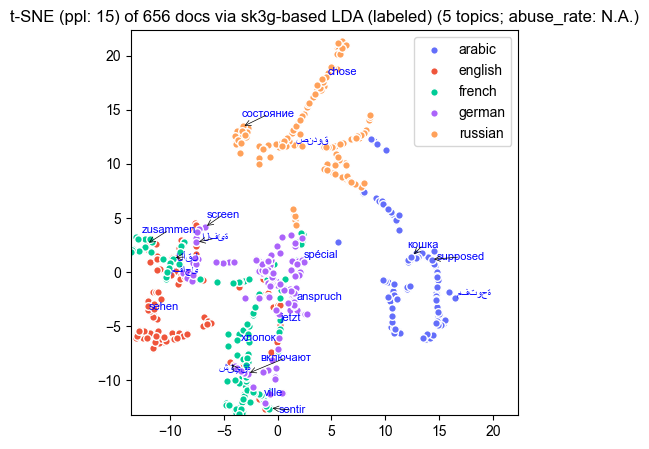

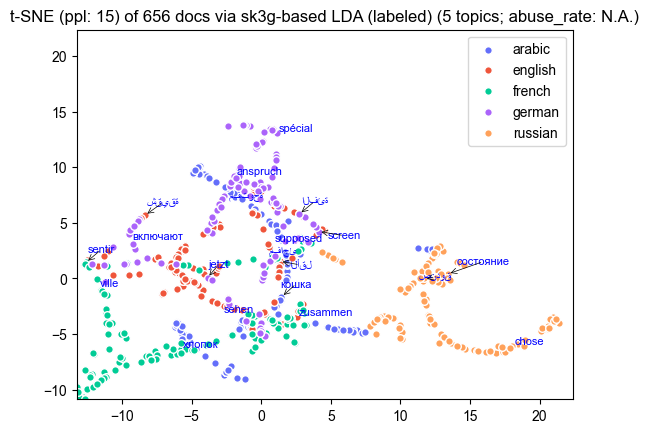

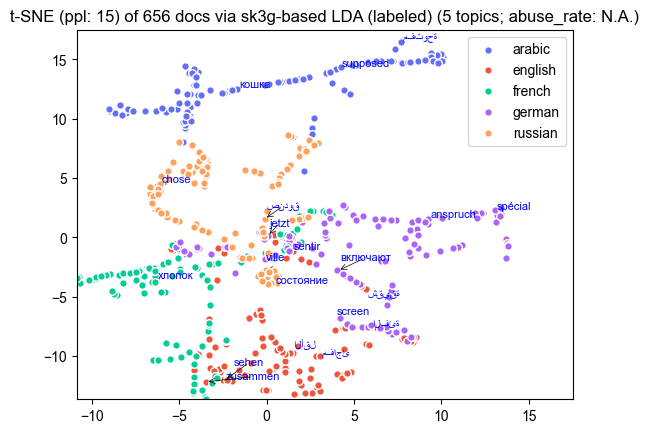

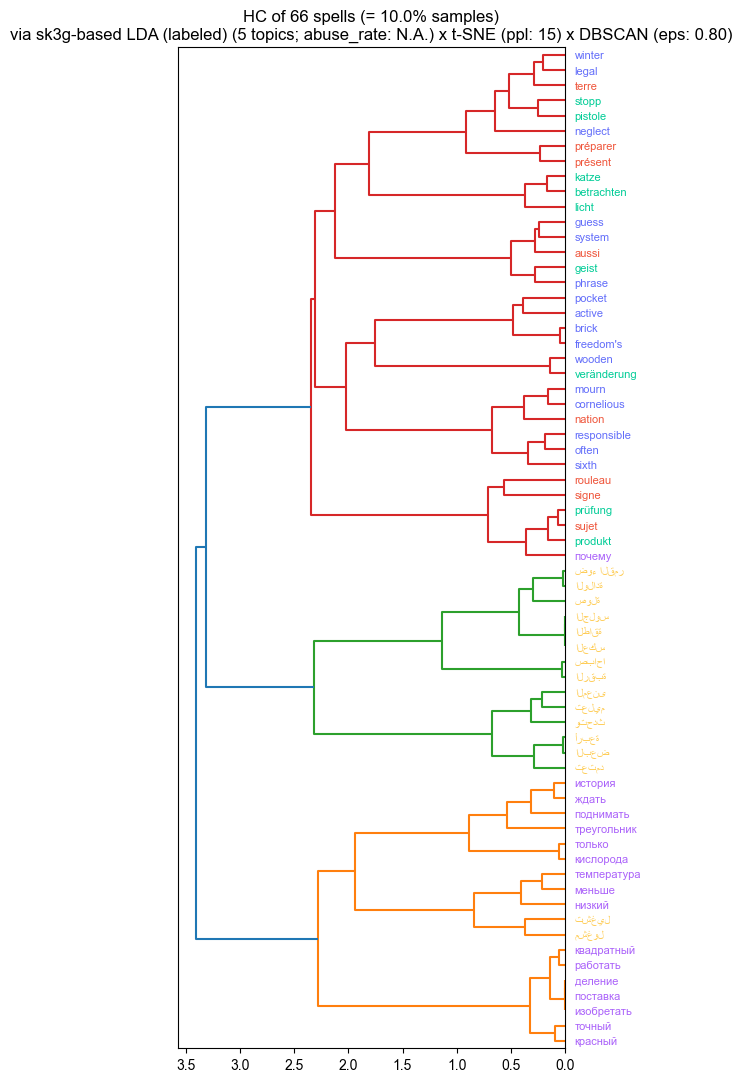

processing: sk2gram
plot_df:            D1        D2       D3 language  \
0    -8.00769   0.91402  4.62926   french   
1    -8.36116  -5.79807 -7.34377  english   
2     2.77357  12.23941  7.23227  russian   
3    -0.28469  -0.19861 -1.51313  english   
4    -7.76520   2.78896 -2.99495  english   
..        ...       ...      ...      ...   
651 -12.16607   0.59734  4.69367   french   
652  -0.27239  -0.20161 -1.51805   german   
653 -12.69238   0.64216  4.49520   french   
654  18.31968  -1.29876 -9.58841   arabic   
655  11.96612  -2.82624  3.99563   arabic   

                                                   enc     form  cluster  
0    [0.00042712374, 0.00027858457, 0.38893816, 0.0...   chaise        0  
1    [0.0, 0.0, 0.029818365, 0.91137, 0.0, 0.000929...   around        1  
2    [0.0, 0.00040129904, 0.0, 0.0019229794, 0.0, 0...    домой        2  
3    [0.0, 0.0, 0.51781917, 0.0019131677, 0.0, 0.00...    valin        3  
4    [0.0, 0.0, 0.16770278, 0.0013328164, 0.0, 0.00... 

/Volumes/K/opt/anaconda3/envs/py3.11/lib/python3.11/site-packages/radialtree.py:441: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



F_value


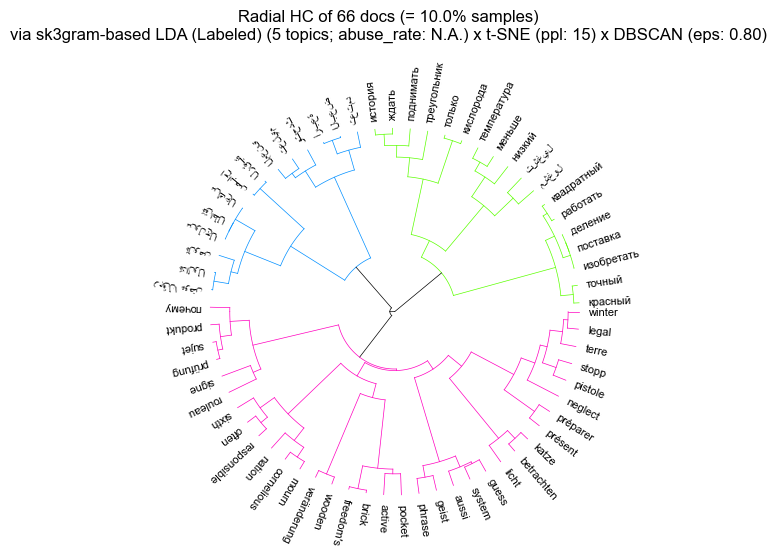

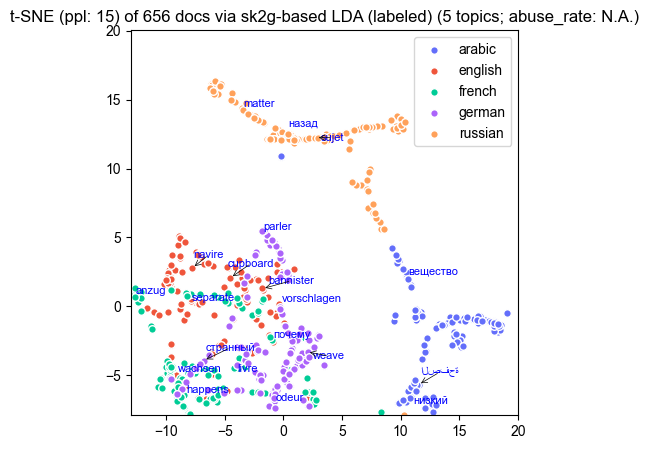

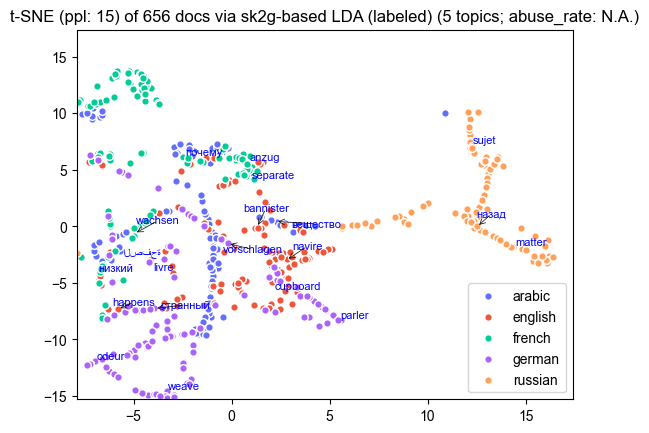

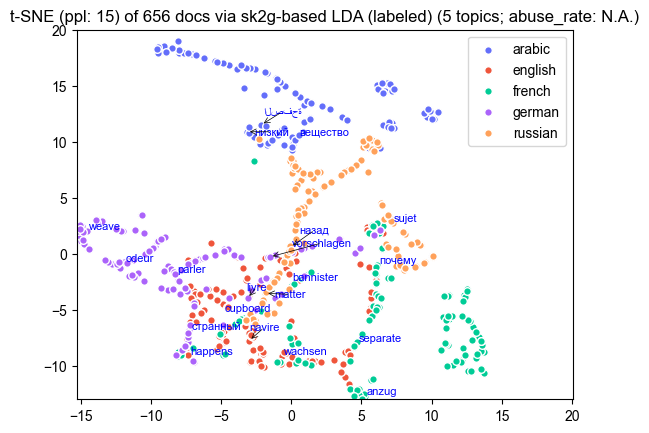

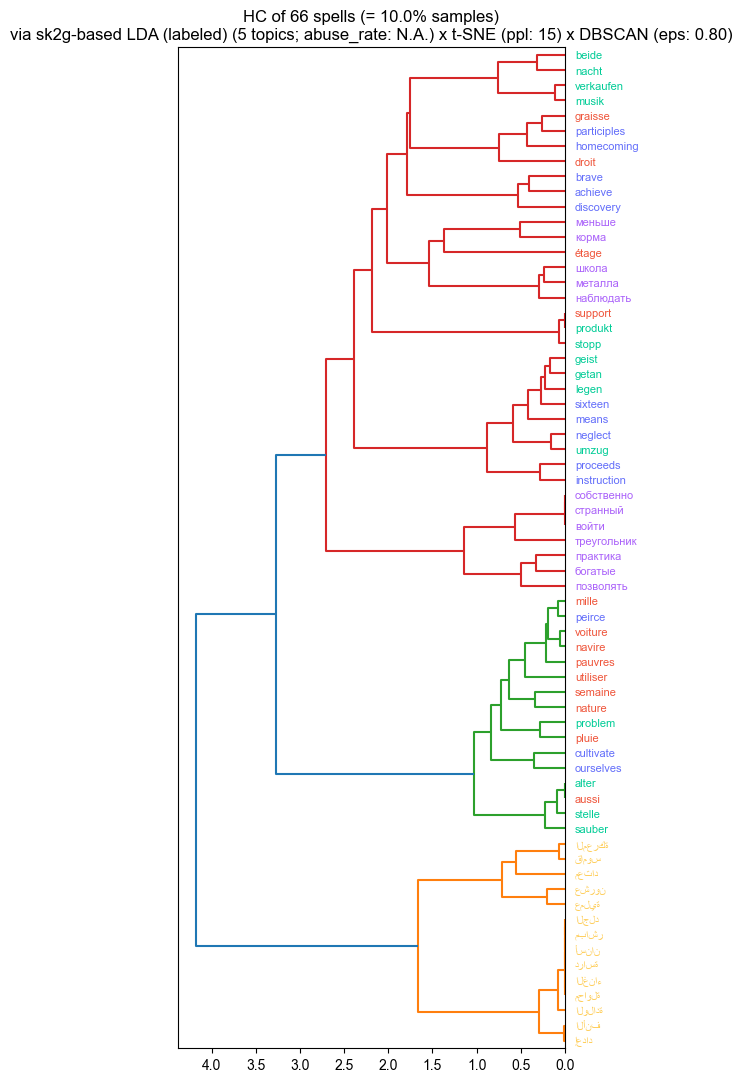

processing: 3gram
plot_df:            D1        D2        D3 language  \
0    25.63278  -8.00338 -10.41087   french   
1   -11.08400 -19.45078 -10.00337  english   
2    12.71540  27.42896   3.24414  russian   
3    14.16137  -1.74737  28.44057  english   
4    -9.18188   9.44648  -1.55191  english   
..        ...       ...       ...      ...   
651  29.17822  -5.05273  -5.07671   french   
652   9.78380 -24.01142 -22.60999   german   
653  22.38877 -11.16346  -7.90530   french   
654  21.04787   6.89441 -25.50597   arabic   
655  30.61038  -2.04734  19.27345   arabic   

                                                   enc     form  cluster  
0    [0.00045493818, 0.00092857366, 0.005182702, 0....   chaise        0  
1    [0.0, 0.0, 0.61003673, 0.38316998, 0.0, 0.0019...   around        1  
2    [0.0, 0.001617614, 0.0, 0.008723183, 0.0, 0.0,...    домой        2  
3    [0.0, 0.0, 0.0071897395, 0.9840257, 0.0, 0.002...    valin        3  
4    [0.0, 0.0, 0.23223878, 0.0053719664, 0.0

/Volumes/K/opt/anaconda3/envs/py3.11/lib/python3.11/site-packages/radialtree.py:441: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



F_value


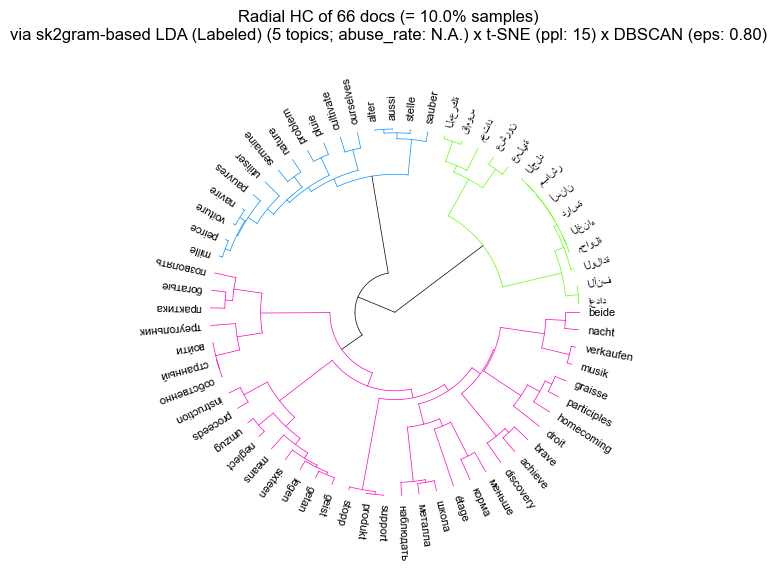

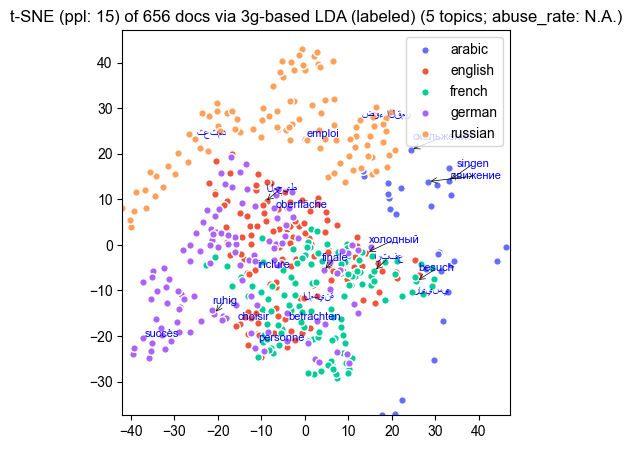

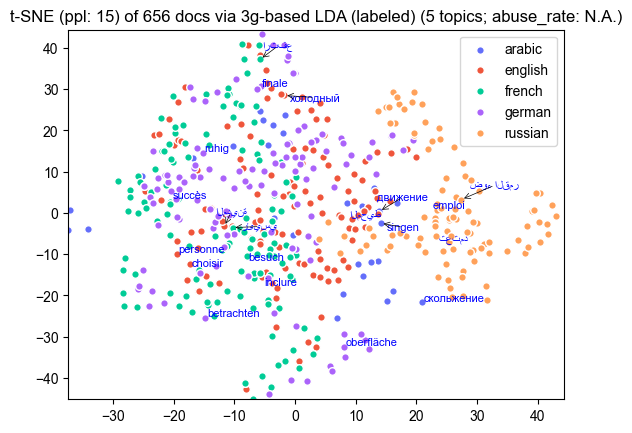

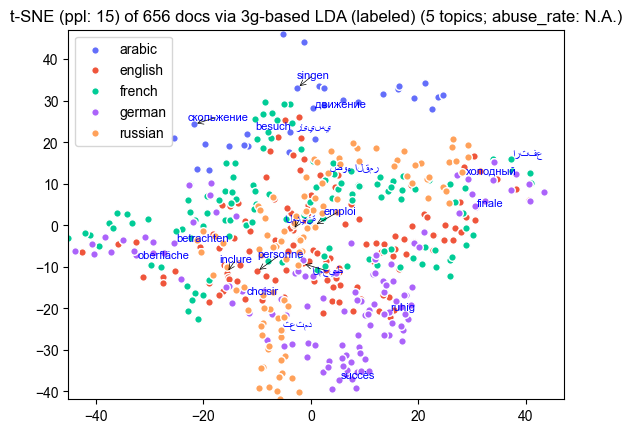

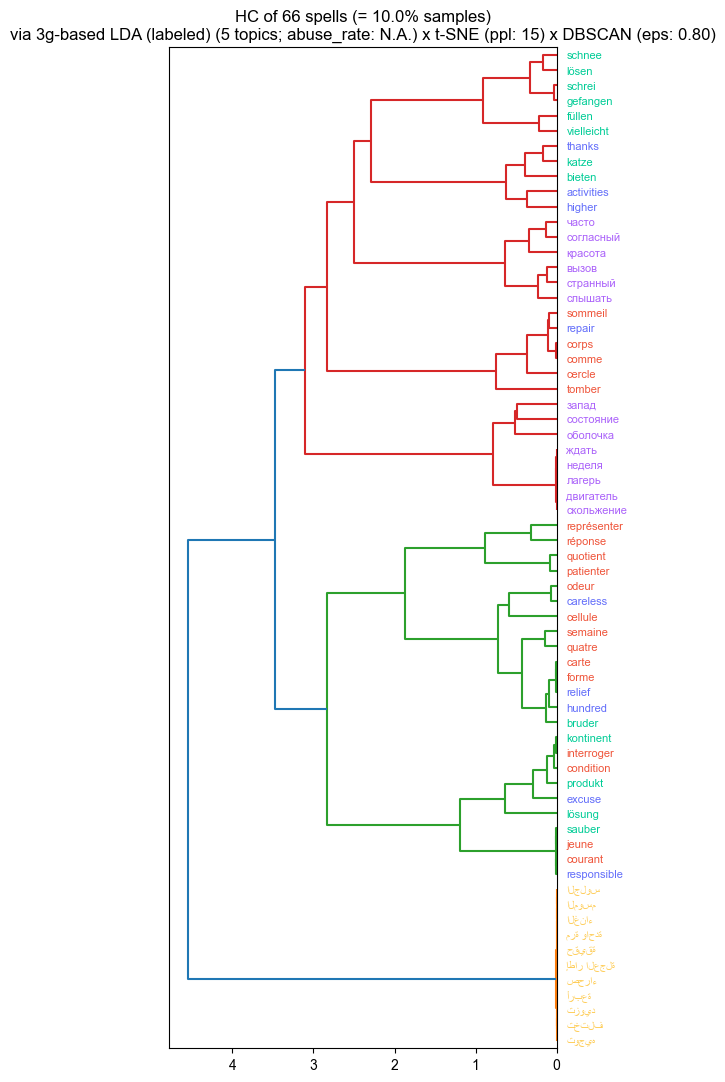

processing: 2gram
plot_df:            D1        D2        D3 language  \
0    34.94662   1.00773 -23.95174   french   
1    14.10587   8.94816  -5.31678  english   
2   -25.46613  -8.13109 -27.17134  russian   
3     8.57023  19.04702  11.34132  english   
4    -6.78868   6.79894   0.35116  english   
..        ...       ...       ...      ...   
651  32.49504   0.34345 -31.45415   french   
652   9.39501   1.70655 -22.30035   german   
653  -7.40651  -1.20678  50.43342   french   
654  -5.88809  36.76888  13.58167   arabic   
655  -2.34960  40.50163 -20.93544   arabic   

                                                   enc     form  cluster  
0    [0.0008665224, 0.00037559468, 0.99063027, 0.00...   chaise        0  
1    [0.0, 0.0, 0.8103307, 0.0052681617, 0.0, 0.001...   around        1  
2    [0.0, 0.0005182799, 0.0, 0.0072859023, 0.0, 0....    домой       -1  
3    [0.0, 0.0, 0.44427058, 0.54802465, 0.0, 0.0020...    valin        2  
4    [0.0, 0.0, 0.45419422, 0.0943023, 0.0, 0

/Volumes/K/opt/anaconda3/envs/py3.11/lib/python3.11/site-packages/radialtree.py:441: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



F_value


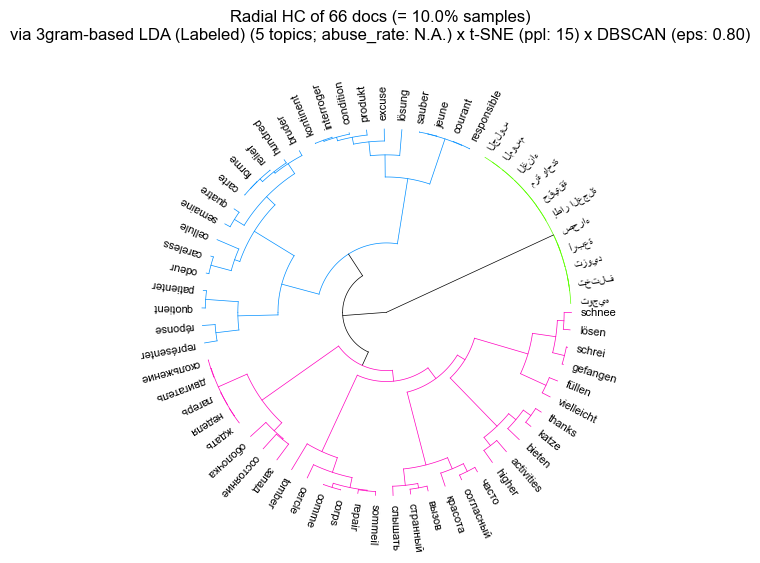

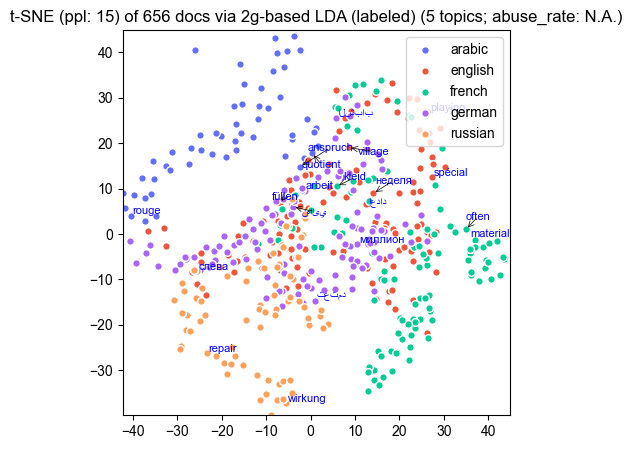

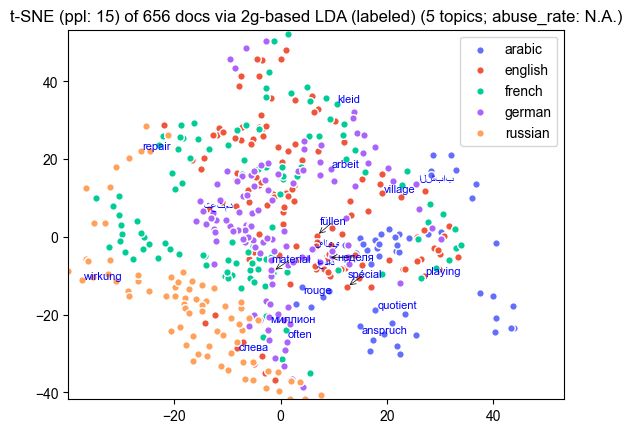

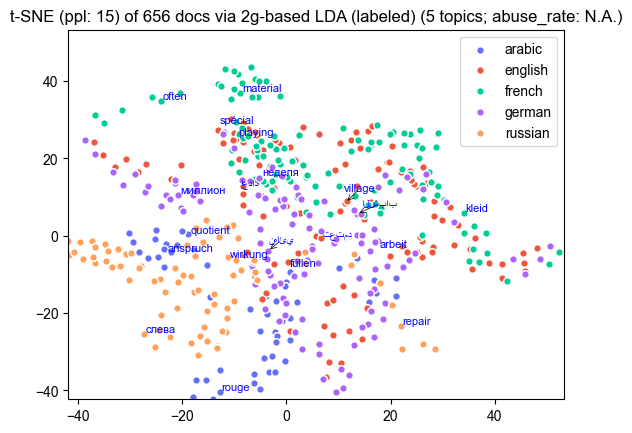

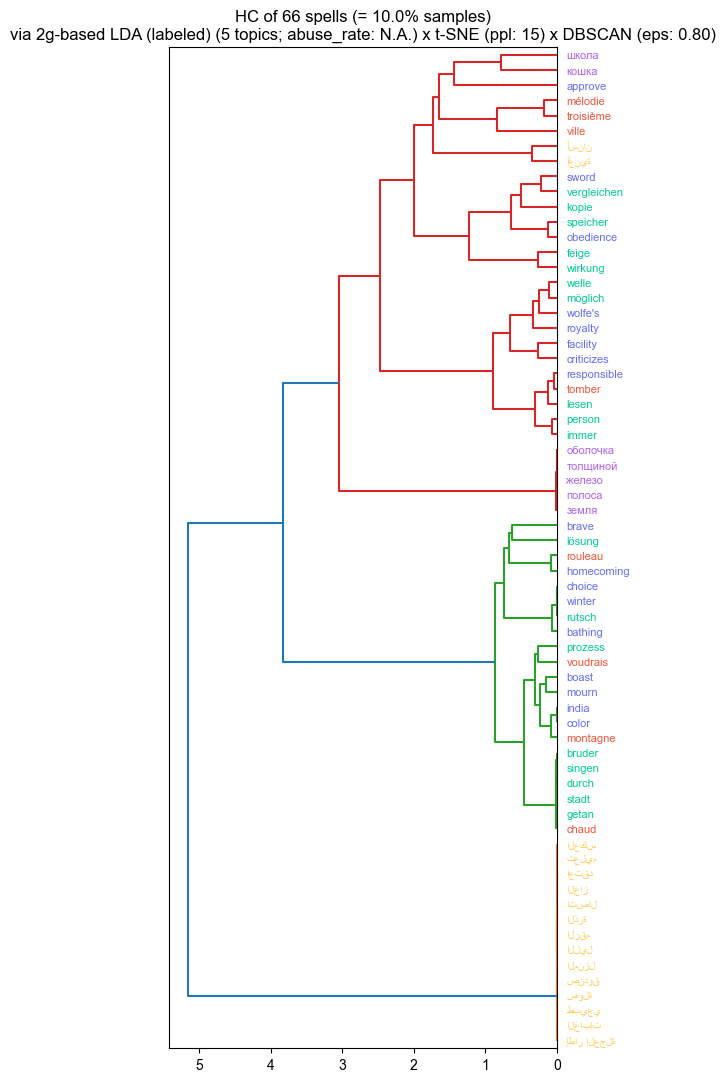

/Volumes/K/opt/anaconda3/envs/py3.11/lib/python3.11/site-packages/radialtree.py:441: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



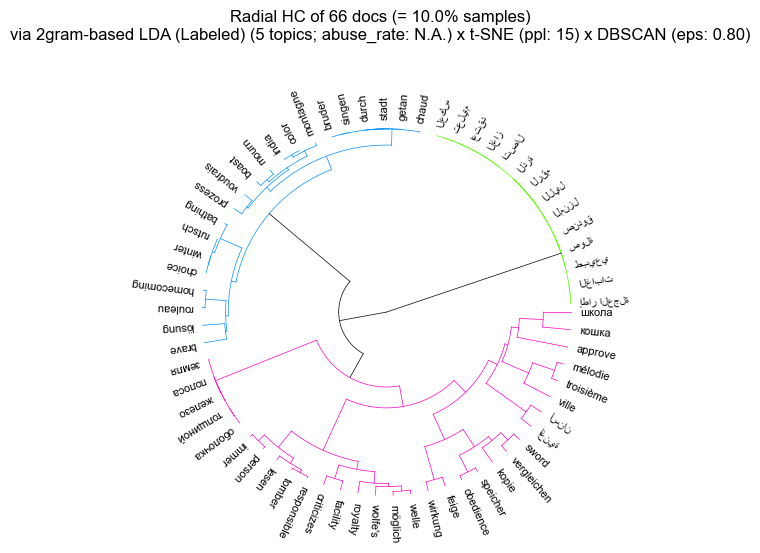

In [829]:
## main 可視化の実行: 3D, 2D, HC, Polar HC
import numpy as np

#
if use_labeled_LDA:
    term_abuse_rate = "N.A."
##
target_term_types = used_term_types
target_term_types = target_term_types[1:]
print(f"target_term_types: {target_term_types}")
##
dominancy_text = "; ".join([f"{k}={v:0.2f}" for k, v in dominancy_dict.items()])
purity_text    = "; ".join([f"{k}={v:0.2f}" for k, v in purity_dict.items()])
##
for term_type in target_term_types[::-1]:
    print(f"processing: {term_type}")
    ##
    plot_df = plot_dfs[term_type]
    print(f"plot_df: {plot_df}")
    
    ## title
    if   dim_reducer == 'ICA':
        dim_reduct_text = f"ICA"
    elif dim_reducer == 'PCA':
        dim_reduct_text = f"PCA"
    elif dim_reducer == 'PLS':
        dim_reduct_text = f"PLS"
    elif dim_reducer == 'MDS':
        dim_reduct_text = f"MDS"
    elif dim_reducer == 'LLE':
        dim_reduct_text = f"LLE (n_ngh: {lle_n_neighbors})"
    elif dim_reducer == 'Isomap':
        dim_reduct_text = f"Isomap (n_ngh: {isomap_n_neighbors})"
    elif dim_reducer == 'tSNE':
        dim_reduct_text = f"t-SNE (ppl: {doc_perplexity_val})"
    elif dim_reducer == 'UMAP':
        dim_reduct_text = f"UMAP (n_ngh: {umap_n_neighbors})"
    else:
        dim_reduct_text = f"X"
    ##
    if use_labeled_LDA:
        title_val = f"{dim_reduct_text} of {len(plot_df)} docs via {term_type[:-3]}-based {encoding_method} ({n_topics} topics; abuse_rate: N.A.)"
    else:
        title_val = f"{dim_reduct_text} of {len(plot_df)} docs via {term_type[:-3]}-based {encoding_method} ({n_topics} topics; abuse_rate: {term_abuse_rate:0.2f})"
    
    ## 3D可視化: coloring for language
    draw_3D_plot (plot_df, color_var = 'language', title = title_val, check = False)
    
    ## 3D可視化: coloring for cluster
    draw_3D_plot (plot_df, color_var = 'cluster', title = title_val, check = False)

    ## F_value の表示
    print(f"F_value")
    F_value_df
    
    ## 2D可視化
    draw_2D_plots (plot_df, color_var = 'language', label_var = 'form', title = title_val, check = False)

    ## HC
    dendrog, hc_sampling_rate, hc_sample_n = draw_HC_plot (plot_df, dim_reduct_text)

    ## Polar HC
    draw_radial_HC_plot (dendrog, hc_sampling_rate, hc_sample_n, dim_reduct_text)

# 追加解析

In [830]:
run_additionals = False
if not run_additionals:
    import sys
    sys.exit()

SystemExit: 

/Volumes/K/opt/anaconda3/envs/py3.11/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3534: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.



In [ ]:
##pyLDAvis を使った結果の可視化: 階層クラスタリングより詳しい
## ただし一度の実行で一つの term_type しか表示できない

import pyLDAvis
pyLDAvis.enable_notebook()

installed_version = pyLDAvis.__version__
print(f"installed pyLDAvis version: {installed_version}")
if float(installed_version[:3]) > 3.0:
    import pyLDAvis.gensim_models as gensimvis
else:
    import pyLDAvis.gensim as gensimvis
##
target_term_type = used_term_types[-3]
print(f"target_term_type: {target_term_type}")

used_lda_model = lda_model_dict[target_term_type]
used_bots      = bots_dict[target_term_type]
used_diction   = diction_dict[target_term_type]
use_MMDS = False
use_tSNE = False
if use_MMDS:
    vis = gensimvis.prepare(used_lda_model, used_bots, used_diction, n_jobs = n_cores, sort_topics = False, mds = 'mmds')
elif use_tSNE:
    vis = gensimvis.prepare(used_lda_model, used_bots, used_diction, n_jobs = n_cores, sort_topics = False, mds = 'tsne')
else:
    vis = gensimvis.prepare(used_lda_model, used_bots, used_diction, n_jobs = n_cores, sort_topics = False)
pyLDAvis.display(vis) # produces void output

## 上がうまく行かない時の代替案
display_to_browser = False
if display_to_browser:
    for target_term_type in used_term_types:
        print(f"target_term_type: {target_term_type}")

        used_lda_model = lda_model_dict[target_term_type]
        used_bots      = bots_dict[target_term_type]
        used_diction   = diction_dict[target_term_type]
        use_MMDS = False
        use_tSNE = False
        if use_MMDS:
            vis = gensimvis.prepare(used_lda_model, used_bots, used_diction, n_jobs = n_cores, sort_topics = False, mds = 'mmds')
        elif use_tSNE:
            vis = gensimvis.prepare(used_lda_model, used_bots, used_diction, n_jobs = n_cores, sort_topics = False, mds = 'tsne')
        else:
            vis = gensimvis.prepare(used_lda_model, used_bots, used_diction, n_jobs = n_cores, sort_topics = False)
        ##
        ##pyLDAvis.display(vis) # produces void output
        pyLDAvis.show(vis, local = False)

In [ ]:
%%capture --no-display
pyLDAvis.display(vis)

## topics の構造

In [ ]:
for term_type in used_term_types:
    lda_model = lda_model_dict[term_type]
    diction   = diction_dict[term_type]
    #
    n_terms_to_pick = 20 # topic ごとに表示するterm 数の指定
    dfs = [ ]
    import pandas as pd
    for topic in range(n_topics):
        terms = [ ]
        for i, prob in lda_model.get_topic_terms(topic, topn = n_terms_to_pick):
            terms.append(diction.id2token[int(i)])
        #
        dfs.append(pd.DataFrame([terms], index = [ f'topic {topic + 1:02d}' ]))
    ##
    topics = pd.concat(dfs)

    ## table で表示
    topics.T

In [ ]:
## WordCloud のインストールが必要な場合，コメントを外して実行
#!conda install WordCloud -y

In [ ]:
## WordCloud を使った結果の可視化
import numpy as np
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt

show_Japanese = False
if show_Japanese:
    plt.rcParams["font.family"] = "Hiragino Sans"

def color_func(word, font_size, position, orientation, random_state, font_path):
    return 'darkturquoise'

ncols  = 3
nrows  = int(round(n_topics/ncols, 0) + 1)
fig, axs = plt.subplots(ncols = ncols, nrows = nrows, figsize = (9, 15))
axs = axs.flatten()

topN = 20
mask = np.array(Image.open("images/shape-wc-mask-oval.png"))
for i, topic in enumerate(range(lda_model.num_topics)):
    x = dict(lda_model.show_topic(topic, topN))
    im = WordCloud(
        #font_path=font_path,
        background_color = 'lightgrey', colormap = "hsv",
        mask = mask, random_state = 0
    ).generate_from_frequencies(x)
    axs[i].imshow(im)
    axs[i].axis('off')
    axs[i].set_title(f"topic {topic:02d}")

## output 日本語と中国語は文字化けする
plt.tight_layout()
plt.show()

In [ ]:
## topics を確認

import numpy as np
import matplotlib.pyplot as plt
#plt.rcParams['font.family'] = "Lucida Sans Unicode"
from scipy.cluster.hierarchy import dendrogram, linkage


lda_topics = lda_model.get_topics()

## 作図範囲の指定
plt.figure(figsize = (5, round(len(lda_topics) * 0.15)))

## 距離行列の生成
top_linkage = linkage(lda_topics, method = 'ward', metric = 'euclidean')
dendrogram(top_linkage, orientation = 'left')

## 作図
plt.title(f"Hirarchical clustering of {n_topics} topics [0-based] on {term_type[:-2]}-based LDA")
plt.show()

In [ ]:
## t-SNE を使った topic のグループ化 (3D)
import numpy as np
from sklearn.manifold import TSNE as tSNE
## reload
need_reloading = False
if (need_reloading):
    import importlib
    importlib.reload(sklearn.manifold)

## t-SNE のパラメターを設定
## n_components は射影先の空間の次元: n_components = 3 なら3次元空間に射影
## perplexity は結合の強さを表わす指数で，値に拠って結果が代わるので，色々な値を試すと良い
relative = True
if relative:
    top_perplexity_val = round(n_topics * 0.33)
else:
    top_perplexity_val = 5 # 大き過ぎると良くない
print(f"top_perplexity_val: {top_perplexity_val}")
#
try:
    tSNE_3d = tSNE(n_components = 3, perplexity = top_perplexity_val,
                                random_state = 0, max_iter = 1000)
except TypeError:
    tSNE_3d = tSNE(n_components = 3, perplexity = top_perplexity_val,
                                random_state = 0, n_iter = 1000)

## データに適用
T = np.array(list(lda_topics))
topic_tSNE_3d = tSNE_3d.fit_transform(T)

In [ ]:
#!pip3 install "nbformat>=4.2"
#!pip3 install ipykernel
#pip3 install jupyter # reinstall metapackage

In [ ]:
## t-SNE の結果の可視化 (3D)
import plotly.graph_objects as go

## 図の大きさを決める
X, Y, Z = topic_tSNE_3d.iloc[:,0], topic_tSNE_3d.iloc[:,1], topic_tSNE_3d.iloc[:,2]
fig = go.Figure(data = [go.Scatter3d(x = X, y = Y, z = Z,
                                     mode = 'markers', marker = dict(size = 7))])

## 3D 散布図にラベルを追加する処理は未実装
fig.update_layout(autosize = False, width = 500, height = 500,)
fig.show()